# **Importing Libraries**

In [ ]:
#Libraries for Data Cleaning
import pandas as pd
import numpy as np
import datetime

#Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#libraries to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for Model Building
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor as XGB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Libraries for Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# **Data Importing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Item_demand.csv")

In [ ]:
#printing first 5 rows
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [ ]:
print("Number of Rows in the dataset: ",df.shape[0])
print("Number of columns in the dataset: ",df.shape[1])


Number of Rows in the dataset:  913000
Number of columns in the dataset:  4


In [ ]:
#checking any missing values in dataset
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
#statistical Information 
df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [ ]:
#checking the data type and number of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
#data_type of date column is object ----> converting into data column to data data_types
df["date"] = pd.to_datetime(df["date"])

In [ ]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [ ]:
#deleting dulipcate rows
df=df.drop_duplicates()

In [ ]:
#Grouping the data itemwise and aggregating on sales column 
df = df.groupby(['item','date']).agg({'sales':'sum'}).reset_index()
df = df.set_index('date',drop = True)
df

item  sales
date                   
2013-01-01     1    133
2013-01-02     1     99
2013-01-03     1    127
2013-01-04     1    145
2013-01-05     1    149
...          ...    ...
2017-12-27    50    511
2017-12-28    50    587
2017-12-29    50    596
2017-12-30    50    612
2017-12-31    50    626

[91300 rows x 2 columns]

In [ ]:
#rolling sum for 90 days since we are going to predict the next three month sales
df_agg = df.groupby(['item']).rolling(90).sum().shift(-90).dropna().reset_index()
df_agg

item       date    sales
0         1 2013-01-01  12848.0
1         1 2013-01-02  12936.0
2         1 2013-01-03  13019.0
3         1 2013-01-04  13103.0
4         1 2013-01-05  13153.0
...     ...        ...      ...
86844    50 2017-09-28  62200.0
86845    50 2017-09-29  61962.0
86846    50 2017-09-30  61687.0
86847    50 2017-10-01  61392.0
86848    50 2017-10-02  61395.0

[86849 rows x 3 columns]

# **Data Visualization(EDA)**

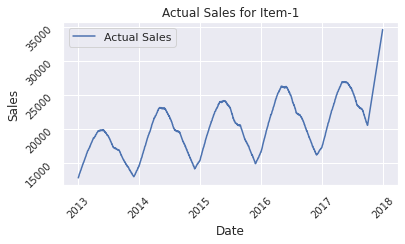

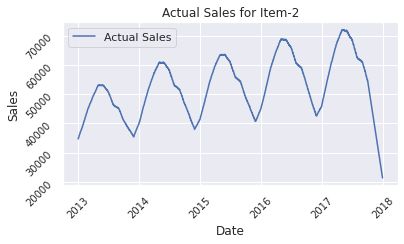

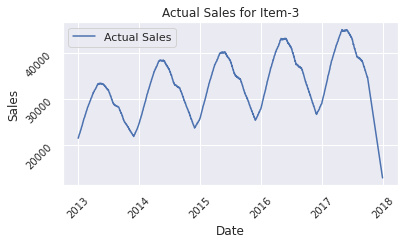

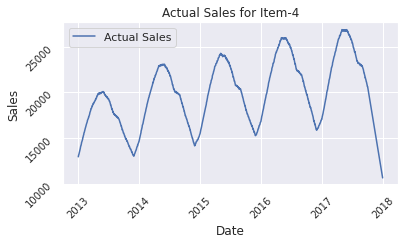

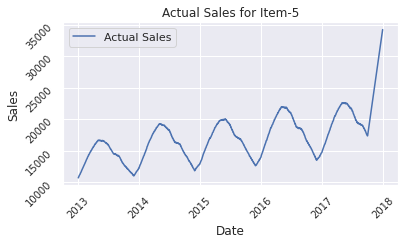

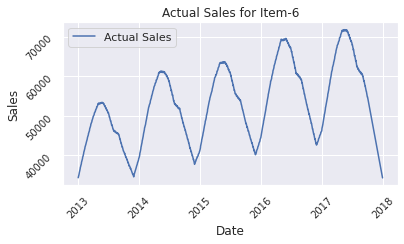

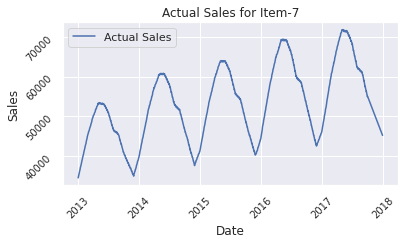

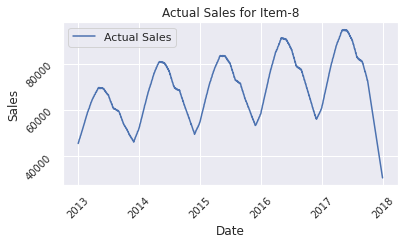

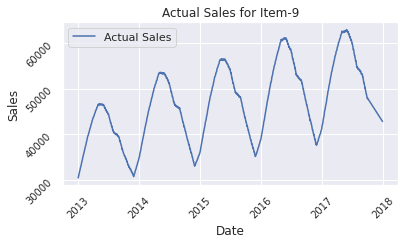

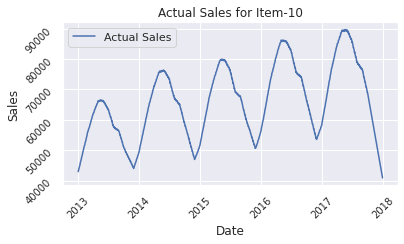

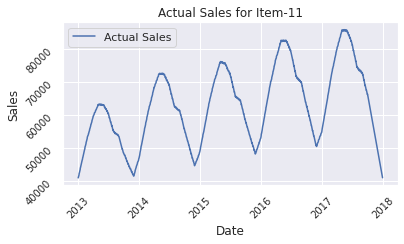

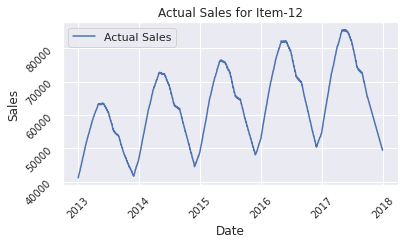

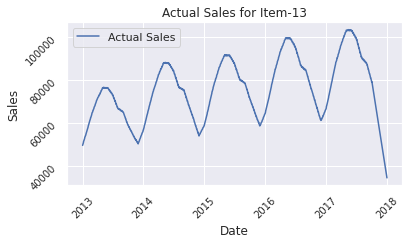

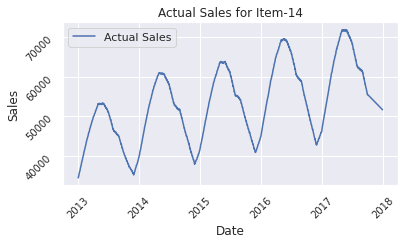

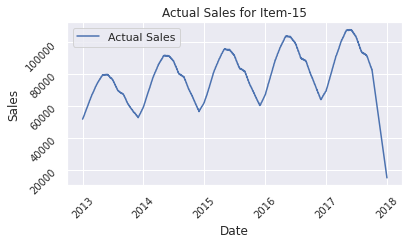

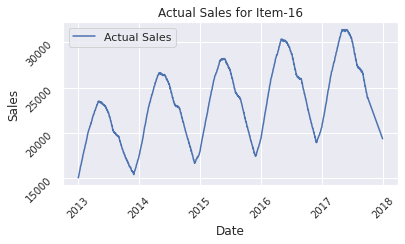

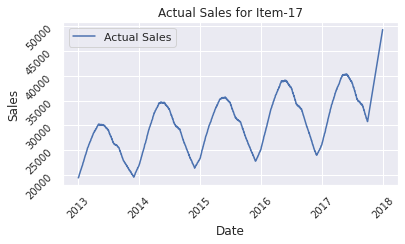

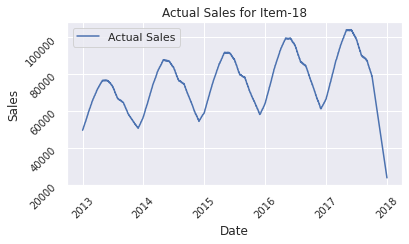

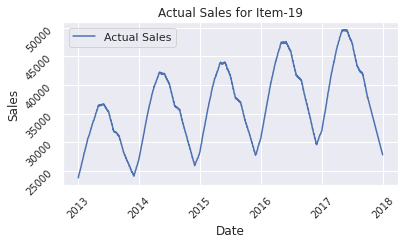

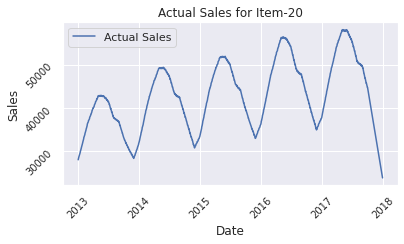

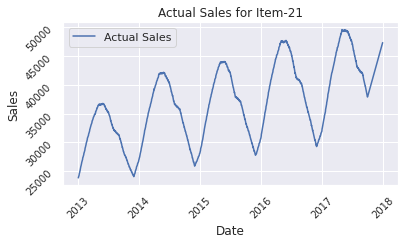

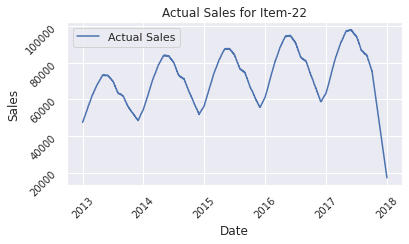

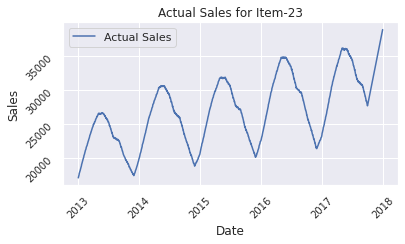

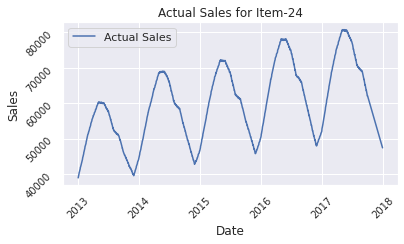

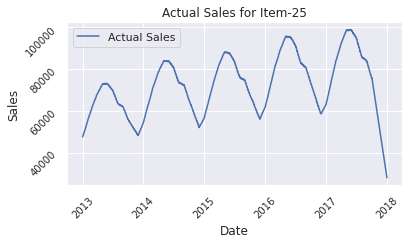

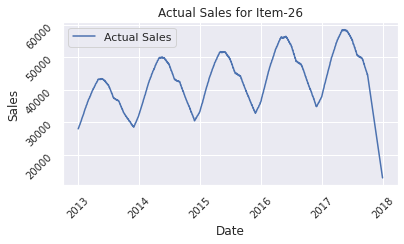

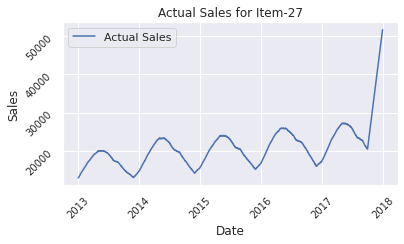

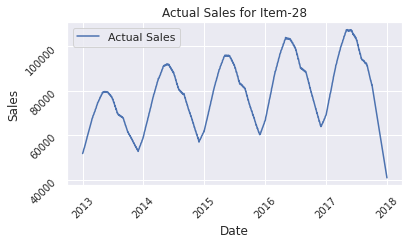

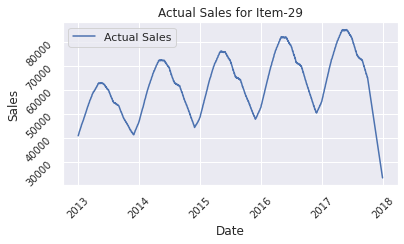

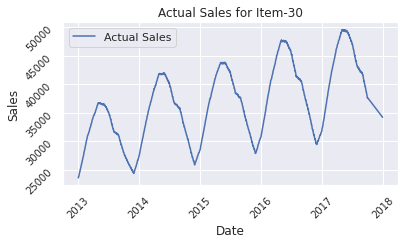

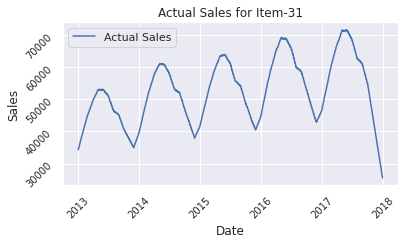

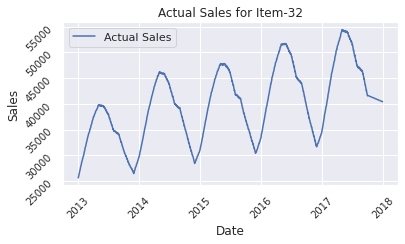

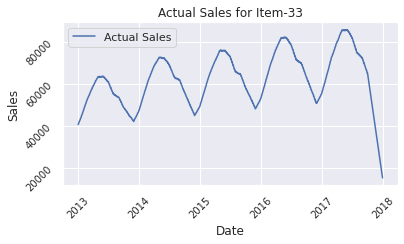

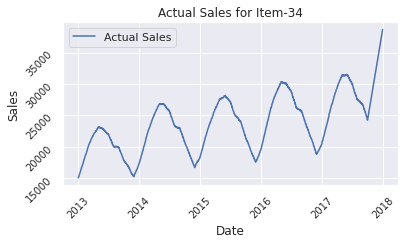

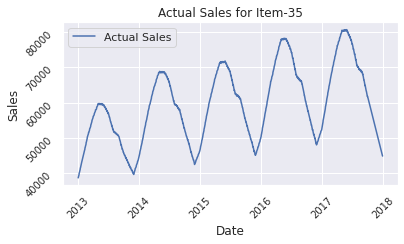

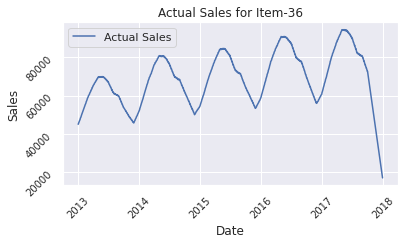

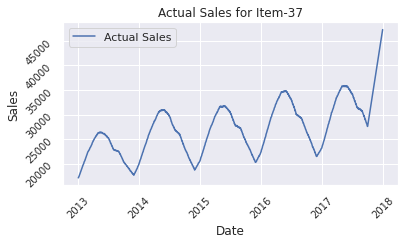

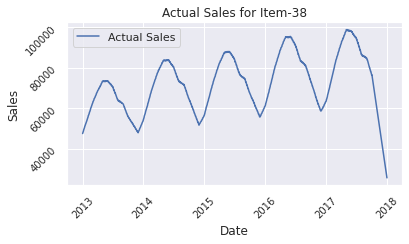

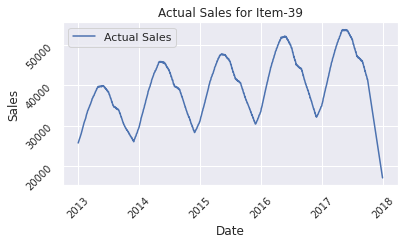

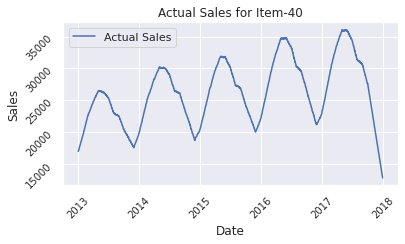

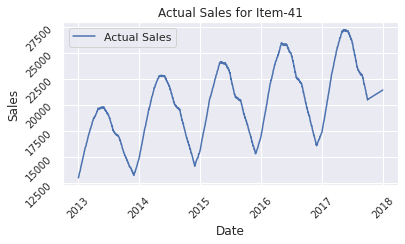

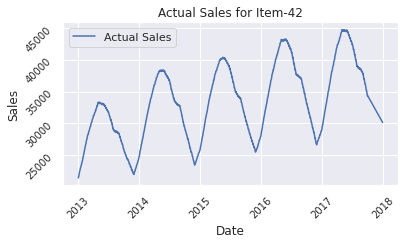

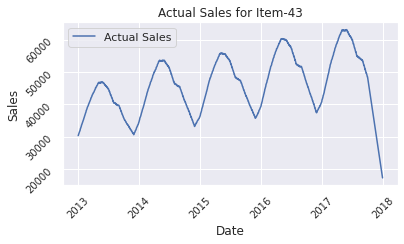

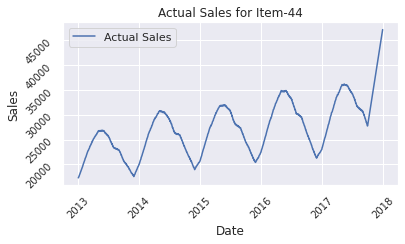

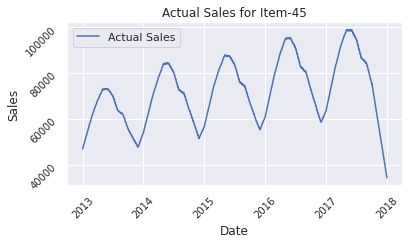

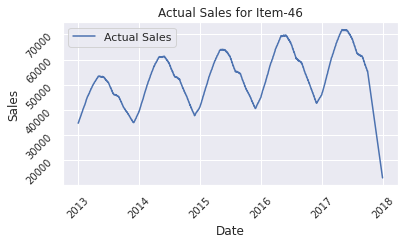

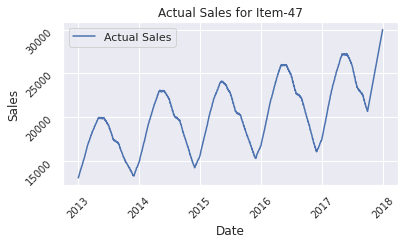

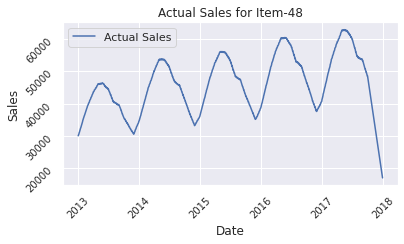

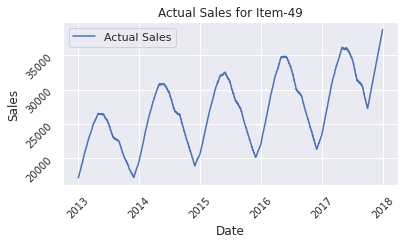

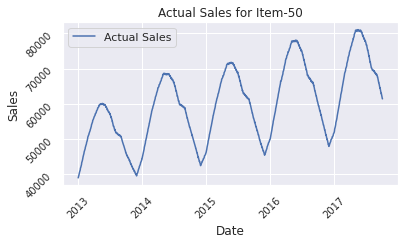

In [ ]:
#visualizing the actual sales for every ite
for i in range(1,51): 
  plot_df = df_agg.loc[df_agg['item'] == i]
  plt.figure(figsize=(6,3))
  plt.plot(plot_df['date'], plot_df['sales'], label='Actual Sales')
  plt.title('Actual Sales for Item-{}'.format(i), size=12)
  plt.xlabel('Date', size=12)
  plt.ylabel('Sales', size=12)
  plt.xticks(rotation=45, size=10)
  plt.yticks(rotation=45, size=10)
  plt.legend(loc='best')
  plt.show()

From the Above graphs, we can clearly see that in the **mid of the every year sales is at peak** for that particular item 

**Feature Engineering**

In [ ]:
df_agg = df_agg.set_index('date', drop=True)

In [ ]:
df_agg

item    sales
date                     
2013-01-01     1  12848.0
2013-01-02     1  12936.0
2013-01-03     1  13019.0
2013-01-04     1  13103.0
2013-01-05     1  13153.0
...          ...      ...
2017-09-28    50  62200.0
2017-09-29    50  61962.0
2017-09-30    50  61687.0
2017-10-01    50  61392.0
2017-10-02    50  61395.0

[86849 rows x 2 columns]

In [ ]:
#Extracting more features from date column
df_agg = df_agg.reset_index()
df_agg['day_of_month'] = df_agg['date'].dt.day
df_agg['month'] = df_agg['date'].dt.month
df_agg['year'] = df_agg['date'].dt.year
df_agg['wk_of_year'] = df_agg['date'].dt.weekofyear
df_agg['quarter'] = df_agg['date'].dt.quarter
df_agg['is_month_start'] = df_agg['date'].dt.is_month_start.astype(int)
df_agg['is_month_end'] = df_agg['date'].dt.is_month_end.astype(int)
df_agg['is_quarter_start'] = df_agg['date'].dt.is_quarter_start.astype(int)
df_agg['is_quarter_end'] = df_agg['date'].dt.is_quarter_end.astype(int)

In [ ]:
df_agg.head()

date  item    sales  day_of_month  month  year  wk_of_year  quarter  \
0 2013-01-01     1  12848.0             1      1  2013           1        1   
1 2013-01-02     1  12936.0             2      1  2013           1        1   
2 2013-01-03     1  13019.0             3      1  2013           1        1   
3 2013-01-04     1  13103.0             4      1  2013           1        1   
4 2013-01-05     1  13153.0             5      1  2013           1        1   

   is_month_start  is_month_end  is_quarter_start  is_quarter_end  
0               1             0                 1               0  
1               0             0                 0               0  
2               0             0                 0               0  
3               0             0                 0               0  
4               0             0                 0               0

In [ ]:
df_agg = df_agg.set_index('date',drop=True)
df_agg.head()

item    sales  day_of_month  month  year  wk_of_year  quarter  \
date                                                                        
2013-01-01     1  12848.0             1      1  2013           1        1   
2013-01-02     1  12936.0             2      1  2013           1        1   
2013-01-03     1  13019.0             3      1  2013           1        1   
2013-01-04     1  13103.0             4      1  2013           1        1   
2013-01-05     1  13153.0             5      1  2013           1        1   

            is_month_start  is_month_end  is_quarter_start  is_quarter_end  
date                                                                        
2013-01-01               1             0                 1               0  
2013-01-02               0             0                 0               0  
2013-01-03               0             0                 0               0  
2013-01-04               0             0                 0               0  
2013-01-05               0             0                 0               0

# **Model Building**

## **Decision Tree model**

In [ ]:
#separate dataset for decison model
df_agg_dt = df_agg.copy()
df_agg_dt.head()

item    sales  day_of_month  month  year  wk_of_year  quarter  \
date                                                                        
2013-01-01     1  12848.0             1      1  2013           1        1   
2013-01-02     1  12936.0             2      1  2013           1        1   
2013-01-03     1  13019.0             3      1  2013           1        1   
2013-01-04     1  13103.0             4      1  2013           1        1   
2013-01-05     1  13153.0             5      1  2013           1        1   

            is_month_start  is_month_end  is_quarter_start  is_quarter_end  
date                                                                        
2013-01-01               1             0                 1               0  
2013-01-02               0             0                 0               0  
2013-01-03               0             0                 0               0  
2013-01-04               0             0                 0               0  
2013-01-05               0             0                 0               0

In [ ]:
# dictionary for collecting the test data forecast results
test_forecast_dict_dt = dict()

# dictionary for collecting the evaluation metrics of the test forecast
em_dict_dt = dict()

In [ ]:
# running a for loop for 50 items
for i in list(df_agg_dt['item'].unique()):
 
  # filtering the data item-wise
  split_data_dt = df_agg_dt[df_agg_dt['item']==i].drop(['item'], axis=1)
  #print(split_data)
  
  # Splitting the dataset into dependent and independent variable
  x_dt = split_data_dt.drop(['sales'], axis=1)
  y_dt = split_data_dt['sales']
  
  #since it is a time series dataset we should split the train and test data 
  #Taking 2013 to 2016 data as train data
  #Taking 2017 data as test data

  x_train_dt = x_dt.loc[:'2016-12-31']
  x_test_dt = x_dt.loc['2017-01-01':'2017-10-02'] 
  y_train_dt = y_dt.loc[:'2016-12-31']
  y_test_dt = y_dt.loc['2017-01-01':'2017-10-02']

  # Initializing the model
  dtr_model = DecisionTreeRegressor(max_depth=10)
  
  # Fitting the data 
  dtr_model.fit(x_train_dt, y_train_dt)
  
  # predicting the test data
  y_pred_dt = dtr_model.predict(x_test_dt)

  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i) #key
  v = y_pred_dt #value
  
  test_forecast_dict_dt.update({k:v})

  #Evaluation Metrics
  r2_dt = r2_score(y_test_dt, y_pred_dt)
  mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
  rmse_dt = np.sqrt(mse_dt)
  mae_dt = mean_absolute_error(y_test_dt, y_pred_dt)
  mape_dt = mean_absolute_percentage_error(y_test_dt, y_pred_dt)

  key_dt = 'Item_'+str(i)
  value_dt = {'r2':r2_dt, 'MSE':mse_dt, 'RMSE':rmse_dt, 'MAE':mae_dt, 'MAPE':mape_dt}
  em_dict_dt.update({key_dt:value_dt})

In [ ]:
# creating a dataframe from dictionary 
test_forecast_dict_dt_df = pd.DataFrame(test_forecast_dict_dt, index=[pd.date_range(start='2017-01-01', end='2017-10-02')])
test_forecast_dict_dt_df = test_forecast_dict_dt_df.reset_index()

In [ ]:
test_forecast_dict_dt_df = test_forecast_dict_dt_df.set_index('level_0', drop=True)

In [ ]:
for i in test_forecast_dict_dt_df.columns:
  test_forecast_dict_dt_df[i] = test_forecast_dict_dt_df[i].apply(lambda x:round(x,2))
test_forecast_dict_dt_df

Item_1   Item_2   Item_3   Item_4   Item_5   Item_6   Item_7  \
level_0                                                                     
2017-01-01  16610.0  44913.0  27781.0  16811.0  14192.0  44466.0  44372.0   
2017-01-02  16703.0  45112.0  28358.5  17234.0  14308.0  45421.0  44659.0   
2017-01-03  16750.0  45304.0  28358.5  17234.0  14308.0  45421.0  44872.0   
2017-01-04  16936.5  45753.0  28358.5  17234.0  14308.0  45421.0  45446.5   
2017-01-05  16936.5  45867.0  28358.5  17234.0  14348.0  45549.0  45446.5   
...             ...      ...      ...      ...      ...      ...      ...   
2017-09-28  19970.0  53957.0  33451.0  20059.0  16778.0  53644.5  53610.5   
2017-09-29  19970.0  53692.0  33316.0  19915.5  16727.0  53644.5  53291.0   
2017-09-30  19829.0  53466.0  33179.0  19915.5  16637.0  53312.0  53028.0   
2017-10-01  19828.0  53257.0  33046.0  19817.0  16562.0  53073.0  52816.0   
2017-10-02  19761.0  53075.0  32978.0  19774.0  16525.0  52850.0  52636.0   

             Item_8   Item_9  Item_10  ...  Item_41  Item_42  Item_43  \
level_0                                ...                              
2017-01-01  58194.0  38866.0  56004.0  ...  16897.0  28024.0  39212.0   
2017-01-02  59566.0  39691.0  57134.0  ...  17286.5  28665.0  39413.0   
2017-01-03  59566.0  39691.0  57134.0  ...  17286.5  28665.0  39585.0   
2017-01-04  59566.0  39691.0  57134.0  ...  17286.5  28665.0  40044.0   
2017-01-05  59729.0  39767.0  57355.0  ...  17286.5  28665.0  40044.0   
...             ...      ...      ...  ...      ...      ...      ...   
2017-09-28  70674.0  47194.0  67346.0  ...  19996.5  33593.0  47114.0   
2017-09-29  70345.0  46979.0  67018.0  ...  19996.5  33350.5  46881.0   
2017-09-30  70085.0  46792.0  66753.0  ...  19832.0  33350.5  46718.0   
2017-10-01  69768.0  46630.0  66502.0  ...  19762.0  33166.0  46555.0   
2017-10-02  69469.0  46454.0  66203.0  ...  19699.0  33047.0  46395.0   

            Item_44  Item_45  Item_46  Item_47  Item_48  Item_49  Item_50  
level_0                                                                    
2017-01-01  22407.0  61122.0  44884.0  16692.0  38751.0  22021.0  50051.0  
2017-01-02  22516.0  62497.0  45111.0  16765.0  39514.0  22135.0  51145.0  
2017-01-03  22662.0  62497.0  45361.0  16847.0  39514.0  22245.0  51145.0  
2017-01-04  22868.0  62497.0  45810.0  17050.0  39514.0  22576.5  51145.0  
2017-01-05  22969.0  62497.0  45942.0  17050.0  39658.0  22576.5  51145.0  
...             ...      ...      ...      ...      ...      ...      ...  
2017-09-28  26770.0  73663.0  53891.0  20254.0  47118.5  26624.0  60293.0  
2017-09-29  26546.5  73391.0  53705.0  20254.0  47118.5  26536.0  59903.0  
2017-09-30  26546.5  73103.0  53445.0  20107.0  46775.0  26436.0  59903.0  
2017-10-01  26429.0  72857.0  53270.0  20070.0  46620.0  26364.0  59619.0  
2017-10-02  26292.0  72602.0  53089.0  19958.0  46518.0  26250.0  59427.0  

[275 rows x 50 columns]

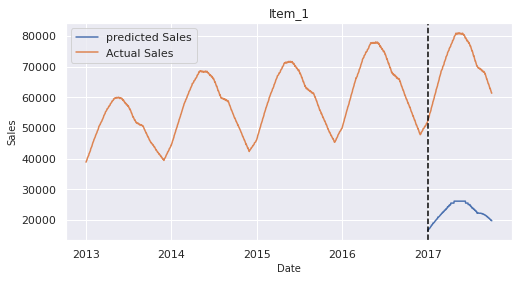

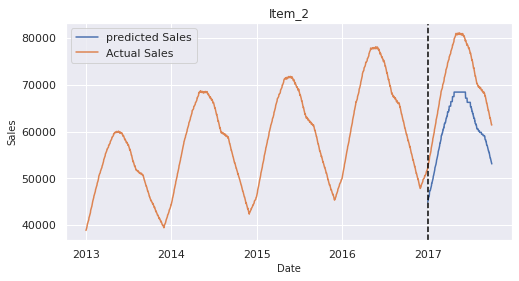

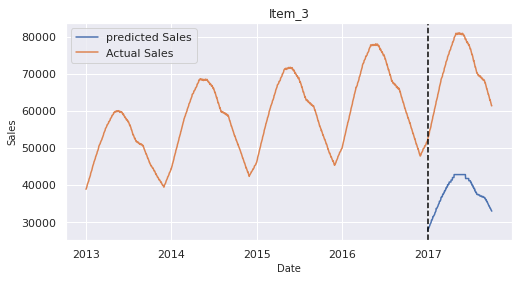

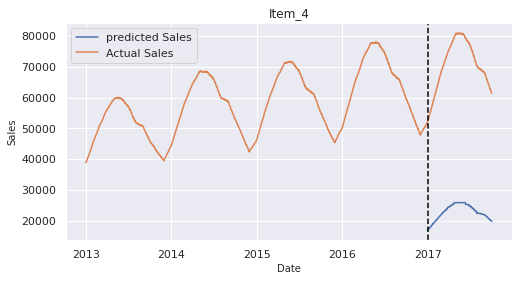

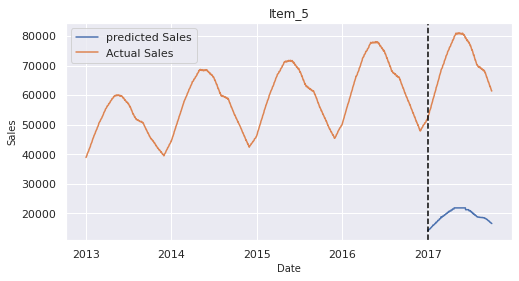

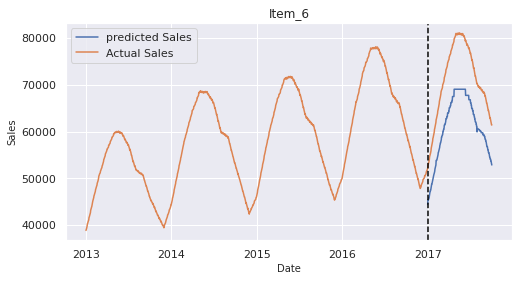

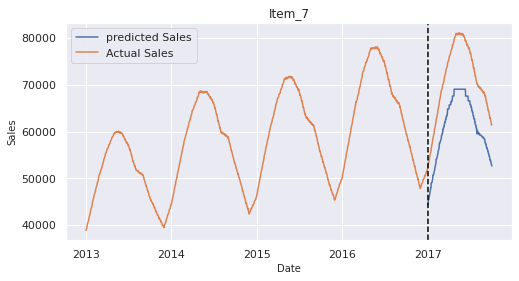

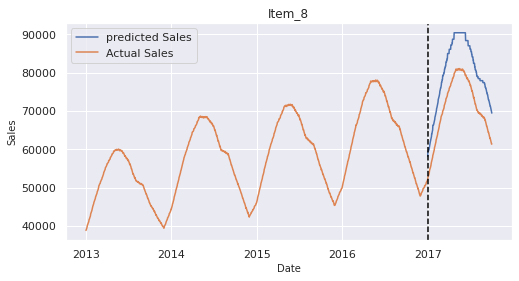

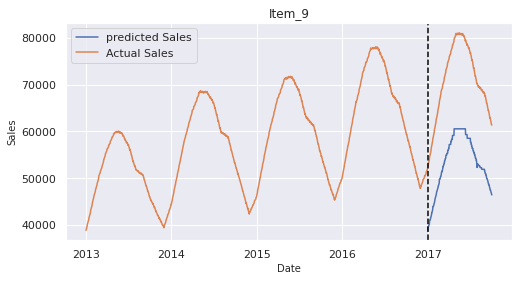

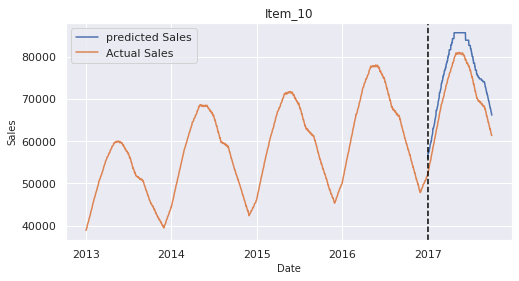

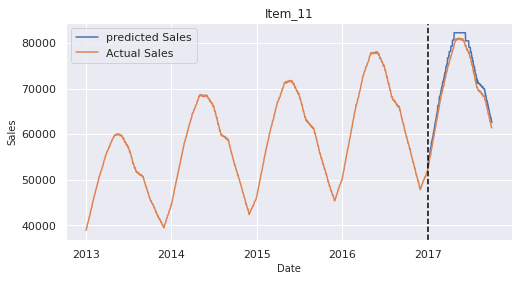

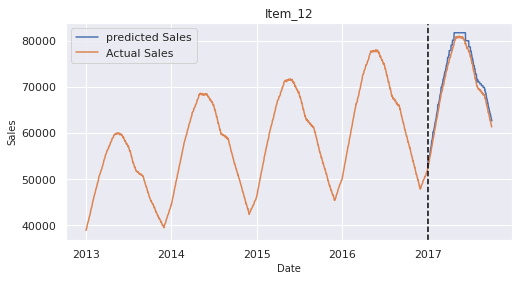

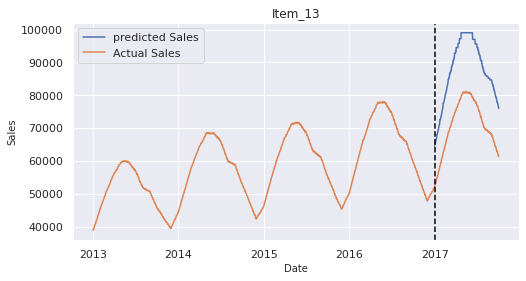

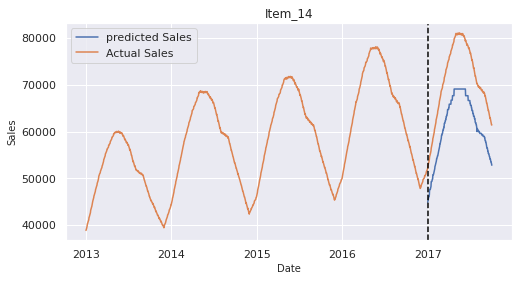

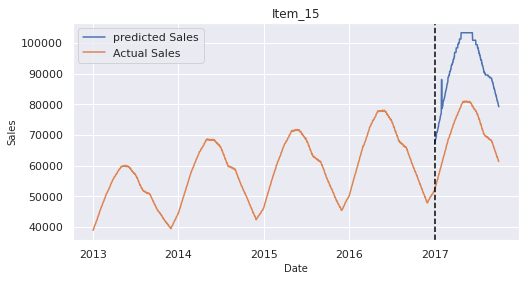

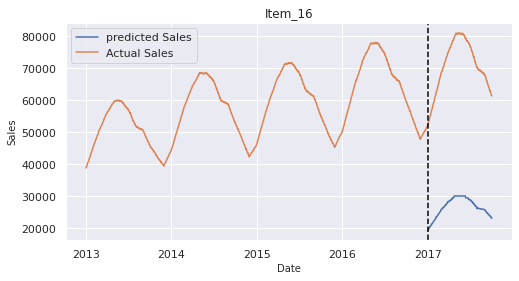

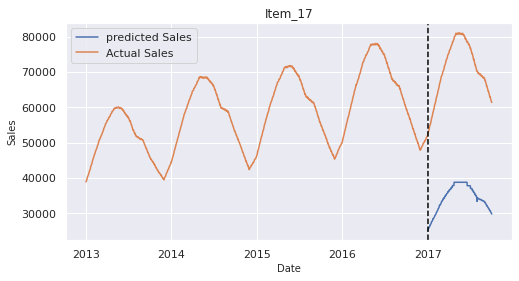

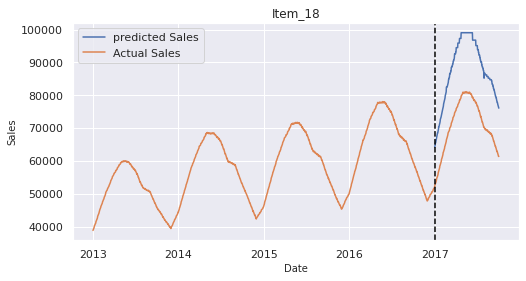

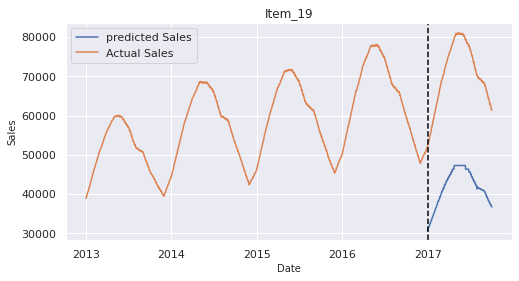

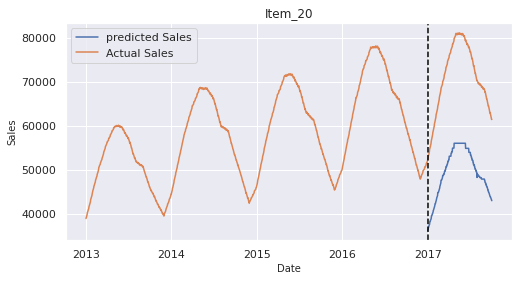

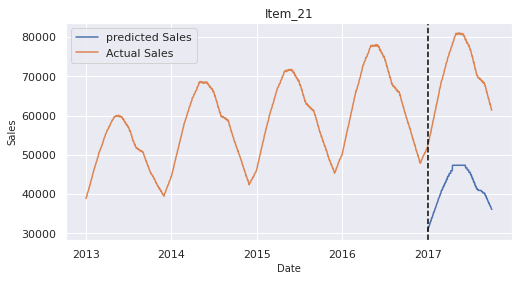

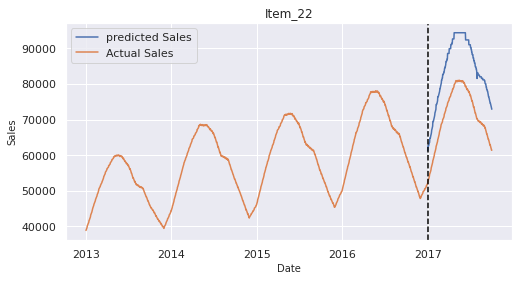

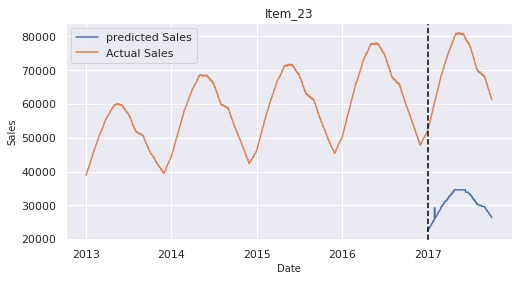

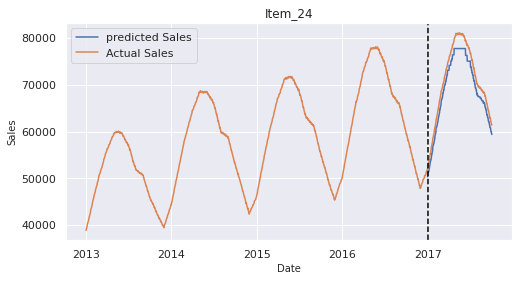

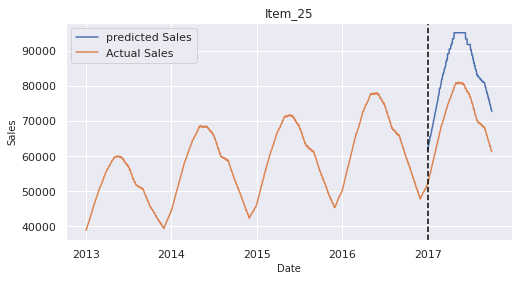

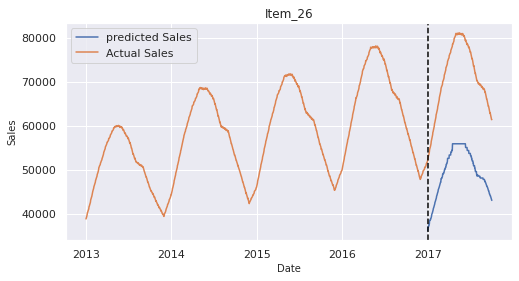

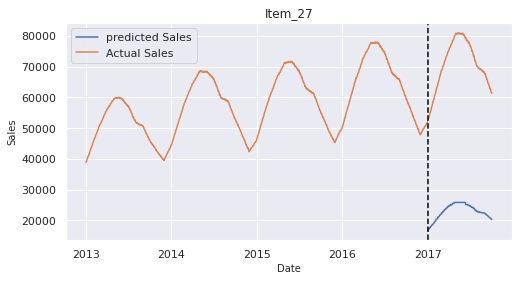

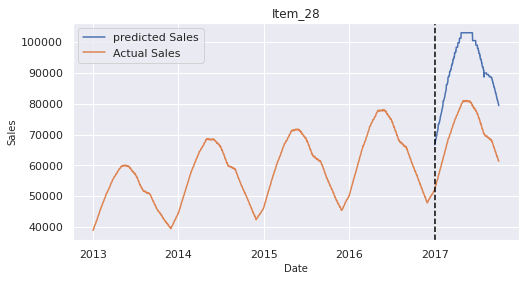

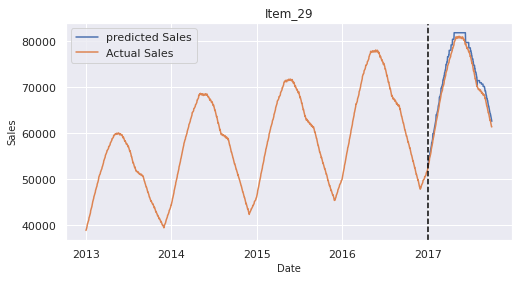

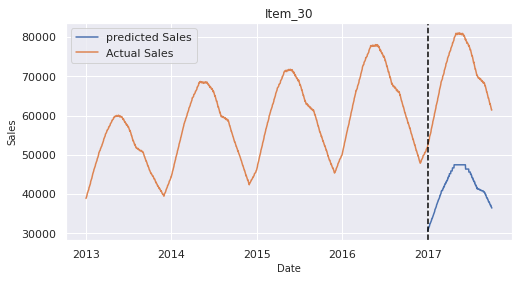

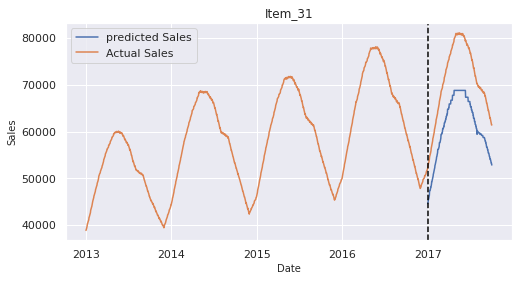

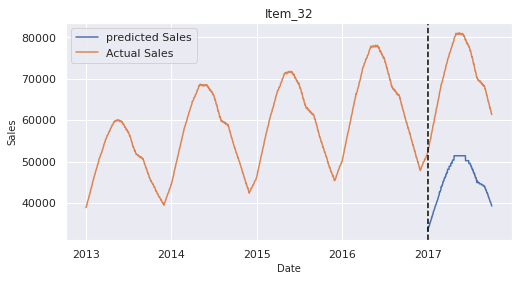

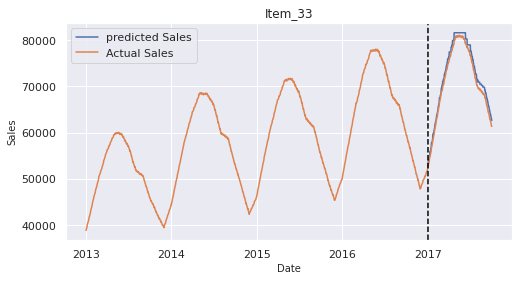

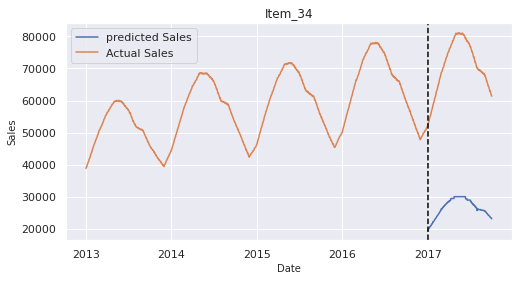

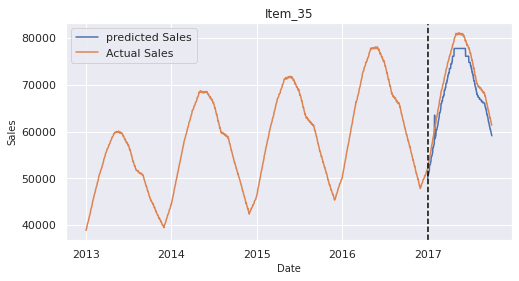

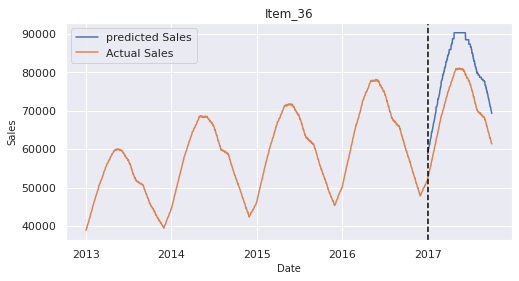

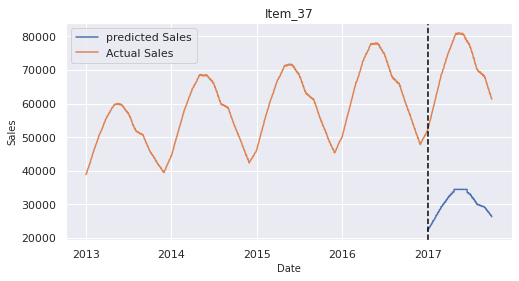

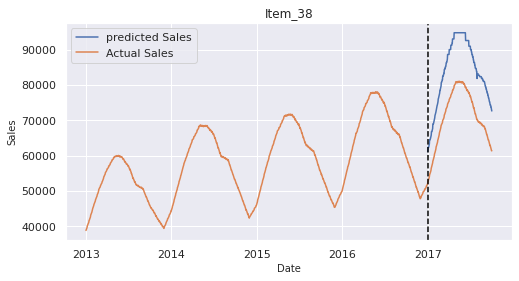

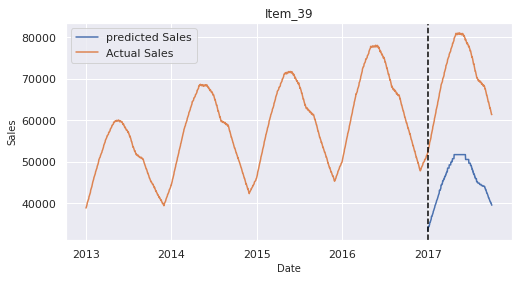

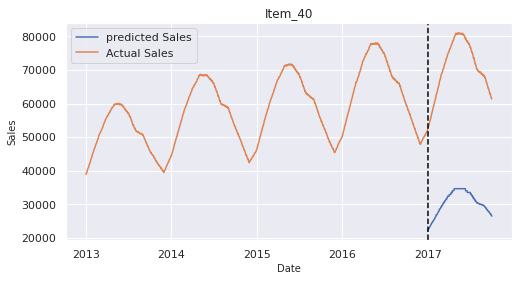

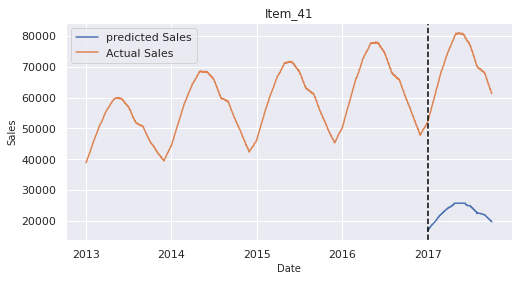

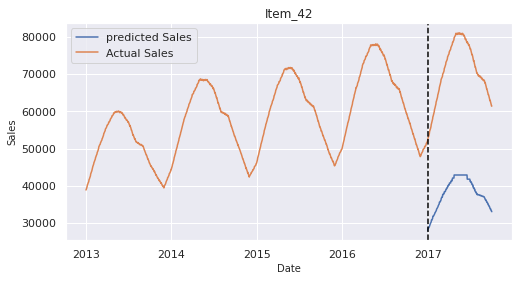

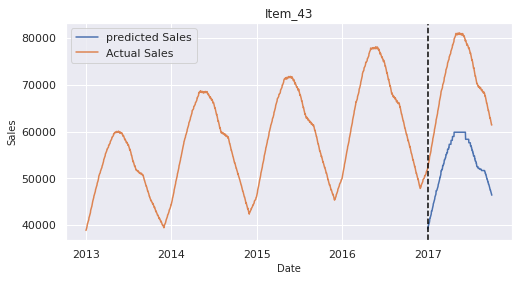

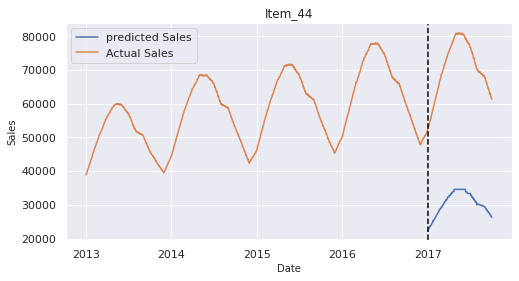

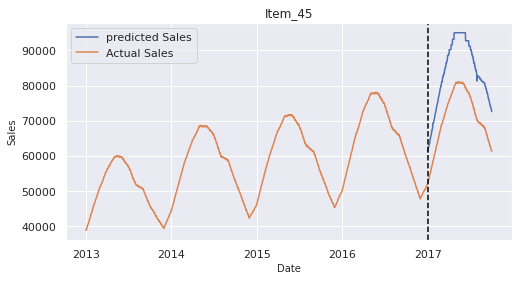

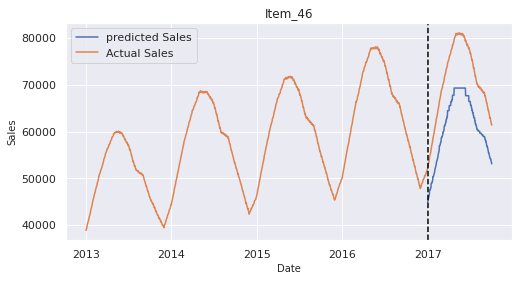

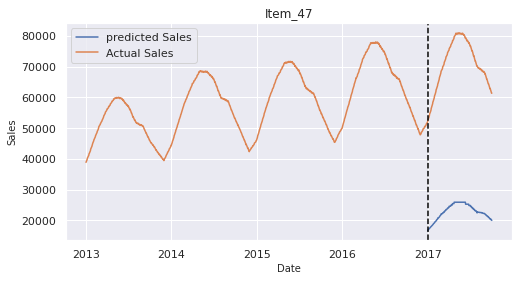

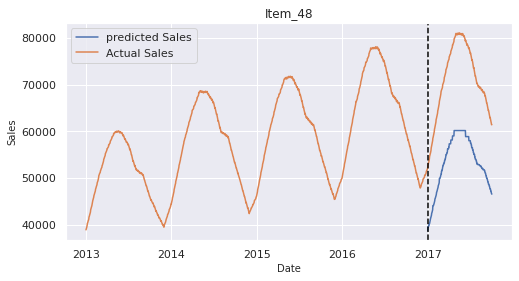

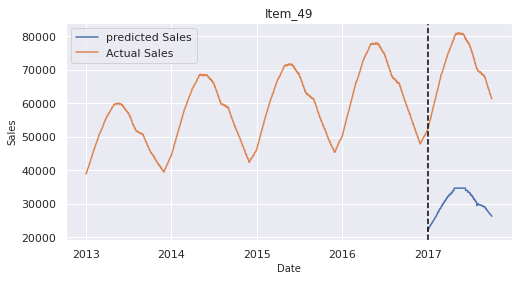

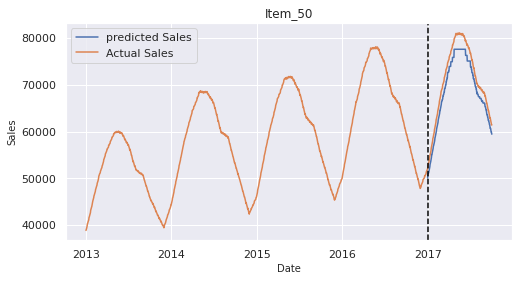

In [ ]:
#visualize the predicted and actual sales 
for k,v in test_forecast_dict_dt.items():
  plotdf_dt = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-02'))
  fig, ax = plt.subplots(figsize=(8,4))
  plt.title('{}'.format(k))
  plt.plot(plotdf_dt, label='predicted Sales')
  plt.plot(split_data_dt.sales, label='Actual Sales')
  plt.xlabel('Date', size=10)
  plt.ylabel('Sales', size=10)  
  ax.axvline(pd.to_datetime('2017-01-01'), color='black', ls='--')  # convert date string to datetime object
  plt.legend(loc='best')
  plt.show()


In [ ]:
# creating a dataframe out of the dictionary that stored the performance metrics of the test forecast

em_dict_dt_df = pd.DataFrame(em_dict_dt)
for i in em_dict_dt_df.columns:
  em_dict_dt_df[i] = em_dict_dt_df[i].apply(lambda x:round(x,2))

em_dict_dt_df.T

r2          MSE     RMSE      MAE  MAPE
Item_1   0.90    670779.99   819.01   792.12  0.03
Item_2   0.87   5952966.55  2439.87  2375.24  0.04
Item_3   0.85   2792245.77  1671.00  1649.00  0.04
Item_4   0.91    627246.53   791.99   760.35  0.03
Item_5   0.90    432144.03   657.38   649.84  0.03
Item_6   0.91   4298740.74  2073.34  2017.46  0.03
Item_7   0.90   4769651.45  2183.95  2145.57  0.03
Item_8   0.86  11390887.03  3375.04  3342.80  0.04
Item_9   0.88   3911607.08  1977.78  1918.16  0.04
Item_10  0.85  10459817.66  3234.16  3202.99  0.04
Item_11  0.88   7775188.03  2788.40  2745.02  0.04
Item_12  0.88   8262199.02  2874.40  2840.89  0.04
Item_13  0.87  12325582.93  3510.78  3473.82  0.04
Item_14  0.89   5148454.00  2269.02  2236.90  0.04
Item_15  0.88  12504041.40  3536.11  3466.29  0.04
Item_16  0.87   1117462.12  1057.10  1037.44  0.04
Item_17  0.92   1161383.39  1077.67  1051.64  0.03
Item_18  0.87  13058554.68  3613.66  3540.49  0.04
Item_19  0.85   3221263.02  1794.79  1759.76  0.04
Item_20  0.88   3484404.95  1866.66  1850.24  0.04
Item_21  0.88   2624121.33  1619.91  1578.44  0.04
Item_22  0.89   9253484.78  3041.95  2996.92  0.03
Item_23  0.89   1313464.25  1146.06  1128.45  0.04
Item_24  0.89   6318434.55  2513.65  2487.96  0.04
Item_25  0.90   8870751.62  2978.38  2925.85  0.03
Item_26  0.87   3756620.26  1938.20  1914.92  0.04
Item_27  0.89    777550.15   881.79   805.96  0.03
Item_28  0.87  12820826.48  3580.62  3536.96  0.04
Item_29  0.86   8628192.74  2937.38  2909.77  0.04
Item_30  0.87   2874588.61  1695.46  1671.30  0.04
Item_31  0.88   5202698.82  2280.94  2236.97  0.04
Item_32  0.82   4926474.63  2219.57  2184.16  0.05
Item_33  0.85   9948744.98  3154.16  3106.13  0.04
Item_34  0.86   1166882.72  1080.22  1044.37  0.04
Item_35  0.88   6953583.53  2636.96  2617.34  0.04
Item_36  0.89   8776910.84  2962.59  2918.78  0.04
Item_37  0.87   1476016.36  1214.91  1199.50  0.04
Item_38  0.88  10575048.38  3251.93  3218.73  0.04
Item_39  0.89   2862934.47  1692.02  1662.09  0.04
Item_40  0.89   1352368.01  1162.91  1151.62  0.04
Item_41  0.87    953354.30   976.40   918.60  0.04
Item_42  0.89   1831664.32  1353.39  1329.83  0.03
Item_43  0.85   5417222.60  2327.49  2284.68  0.04
Item_44  0.88   1394203.71  1180.76  1161.82  0.04
Item_45  0.86  12304919.70  3507.84  3478.88  0.04
Item_46  0.90   4779522.84  2186.21  2148.31  0.03
Item_47  0.85   1049427.56  1024.42   981.83  0.04
Item_48  0.85   5037534.62  2244.45  2215.96  0.04
Item_49  0.84   1890892.70  1375.10  1362.36  0.04
Item_50  0.90   6311633.96  2512.30  2471.56  0.03

**Feature Importance**

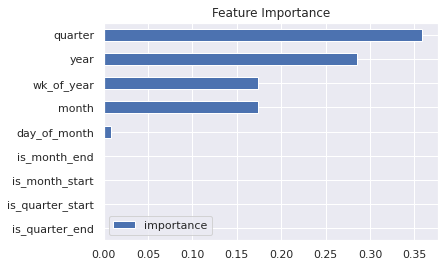

In [ ]:
#visualizing feature importance
feature_importance = pd.DataFrame(data=dtr_model.feature_importances_,
             index=dtr_model.feature_names_in_,
             columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## **Random Forest Model**

In [ ]:
#separate dataframe for model
df_agg_rf = df_agg.copy()
df_agg_rf

item    sales  day_of_month  month  year  wk_of_year  quarter  \
date                                                                        
2013-01-01     1  12848.0             1      1  2013           1        1   
2013-01-02     1  12936.0             2      1  2013           1        1   
2013-01-03     1  13019.0             3      1  2013           1        1   
2013-01-04     1  13103.0             4      1  2013           1        1   
2013-01-05     1  13153.0             5      1  2013           1        1   
...          ...      ...           ...    ...   ...         ...      ...   
2017-09-28    50  62200.0            28      9  2017          39        3   
2017-09-29    50  61962.0            29      9  2017          39        3   
2017-09-30    50  61687.0            30      9  2017          39        3   
2017-10-01    50  61392.0             1     10  2017          39        4   
2017-10-02    50  61395.0             2     10  2017          40        4   

            is_month_start  is_month_end  is_quarter_start  is_quarter_end  
date                                                                        
2013-01-01               1             0                 1               0  
2013-01-02               0             0                 0               0  
2013-01-03               0             0                 0               0  
2013-01-04               0             0                 0               0  
2013-01-05               0             0                 0               0  
...                    ...           ...               ...             ...  
2017-09-28               0             0                 0               0  
2017-09-29               0             0                 0               0  
2017-09-30               0             1                 0               1  
2017-10-01               1             0                 1               0  
2017-10-02               0             0                 0               0  

[86849 rows x 11 columns]

In [ ]:
# dictionary for collecting the test data predicted results
test_forecast_dict_rf = dict()

# dictionary for collecting the evaluation metrics 
em_dict_rf = dict()

In [ ]:
# running a for loop for all 50 items
for i in list(df_agg_rf['item'].unique()):
 
  # filtering the data item-wise
  split_data_rf = df_agg_rf[df_agg_rf['item']==i].drop(['item'], axis=1)
  
  # Splitting the dataset into dependent and independent variable
  x_rf = split_data_rf.drop(['sales'], axis=1)
  y_rf = split_data_rf['sales']

  #since it is a time series dataset we should split the train and test data 
  #Taking 2013 to 2016 data as train data
  #Taking 2017 data as test data
  
  x_train_rf = x_rf.loc[:'2016-12-31']
  x_test_rf = x_rf.loc['2017-01-01':'2017-10-02'] 
  y_train_rf = y_rf.loc[:'2016-12-31']
  y_test_rf = y_rf.loc['2017-01-01':'2017-10-02']


  # Initializing the model
  rf_model = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 15, random_state = 18)
  
  # Fitting the  the model
  rf_model.fit(x_train_rf, y_train_rf)

  # predicting the x-test data
  y_pred_rf = rf_model.predict(x_test_rf)

  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i) #key
  v = y_pred_rf #value
  
  # adding elements to the dictionary
  test_forecast_dict_rf.update({k:v})

  # Performance Evaluation Metrics
  r2_rf = r2_score(y_test_rf, y_pred_rf)
  mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
  rmse_rf = np.sqrt(mse_rf)
  mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
  mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)

  # creating a key and value for test_forecast evaluation metrics dictionary
  key_rf = 'Item_'+str(i)
  value_rf = {'r2':r2_rf, 'MSE':mse_rf, 'RMSE':rmse_rf, 'MAE':mae_rf, 'MAPE':mape_rf}
  em_dict_rf.update({key_rf:value_rf})

In [ ]:
#creatinf the dataframe to store the predicted results
test_forecast_dict_rf_df = pd.DataFrame(test_forecast_dict_rf, index=[pd.date_range(start='2017-01-01', end='2017-10-02')])
test_forecast_dict_rf_df = test_forecast_dict_rf_df.reset_index()

In [ ]:
test_forecast_dict_rf_df = test_forecast_dict_rf_df.set_index('level_0', drop=True)

In [ ]:
#rounding to 2 digits
for i in test_forecast_dict_rf_df.columns:
  test_forecast_dict_rf_df[i] = test_forecast_dict_rf_df[i].apply(lambda x:round(x,2))
test_forecast_dict_rf_df

Item_1    Item_2    Item_3    Item_4    Item_5    Item_6  \
level_0                                                                  
2017-01-01  17082.04  45680.58  28262.32  17170.80  14159.01  44903.17   
2017-01-02  16658.39  44980.63  27925.94  16907.22  14059.22  44695.46   
2017-01-03  16707.78  45104.99  27987.64  16929.07  14088.54  44762.46   
2017-01-04  16828.03  45619.15  28231.86  17076.44  14201.24  45156.30   
2017-01-05  16893.24  45694.45  28304.03  17168.04  14269.98  45319.20   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  19915.62  53662.67  33302.77  19979.25  16651.22  53362.34   
2017-09-29  19785.55  53423.89  33167.92  19928.29  16642.27  53283.47   
2017-09-30  19732.76  52861.82  33005.97  19779.32  16555.03  53034.16   
2017-10-01  19505.58  52419.57  32673.93  19510.57  16279.52  52043.69   
2017-10-02  19494.83  52262.45  32557.48  19494.13  16329.86  52223.10   

              Item_7    Item_8    Item_9   Item_10  ...   Item_41   Item_42  \
level_0                                             ...                       
2017-01-01  45354.98  59228.82  39653.60  57265.85  ...  17153.82  28418.30   
2017-01-02  44485.92  58464.58  38992.57  56191.96  ...  16939.85  28063.44   
2017-01-03  44514.16  58595.68  39111.48  56344.93  ...  16980.23  28120.51   
2017-01-04  45040.16  59229.34  39470.86  56909.29  ...  17171.46  28441.11   
2017-01-05  45281.22  59441.20  39584.94  57115.55  ...  17235.70  28527.26   
...              ...       ...       ...       ...  ...       ...       ...   
2017-09-28  53342.03  70240.32  47054.00  67125.50  ...  19940.07  33441.15   
2017-09-29  53235.38  70067.21  46915.65  66561.82  ...  19860.72  33363.34   
2017-09-30  52737.39  69200.79  46547.65  66182.96  ...  19686.03  32932.32   
2017-10-01  51984.46  68634.30  45767.09  65233.65  ...  19444.14  32682.28   
2017-10-02  51906.24  68583.51  45818.04  65296.73  ...  19434.48  32623.10   

             Item_43   Item_44   Item_45   Item_46   Item_47   Item_48  \
level_0                                                                  
2017-01-01  39692.24  22722.96  62387.05  45419.89  16933.47  39187.01   
2017-01-02  39353.90  22503.13  61471.73  45085.63  16725.80  38985.14   
2017-01-03  39423.20  22564.73  61479.77  45191.22  16764.09  38952.50   
2017-01-04  39762.62  22787.39  62033.47  45692.83  16952.02  39420.35   
2017-01-05  39869.40  22871.68  62374.95  45765.98  16979.35  39483.04   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  46868.35  26649.15  73170.36  53647.43  20195.35  46978.84   
2017-09-29  46844.48  26562.78  73092.91  53372.00  20144.84  46822.42   
2017-09-30  46525.28  26371.31  72896.28  53165.84  19945.03  46718.83   
2017-10-01  45698.09  25949.03  71730.17  52362.32  19740.47  45894.33   
2017-10-02  45738.26  25931.74  71449.82  52438.71  19701.71  45827.37   

             Item_49   Item_50  
level_0                         
2017-01-01  22434.90  50847.48  
2017-01-02  22141.00  50233.94  
2017-01-03  22223.15  50330.76  
2017-01-04  22429.00  50804.00  
2017-01-05  22529.27  50953.10  
...              ...       ...  
2017-09-28  26503.14  59841.57  
2017-09-29  26467.41  59769.29  
2017-09-30  26203.67  59513.05  
2017-10-01  26043.30  58819.97  
2017-10-02  25954.61  58575.55  

[275 rows x 50 columns]

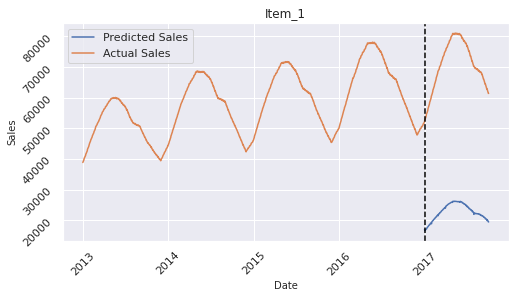

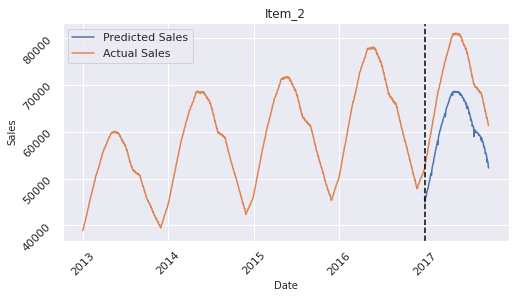

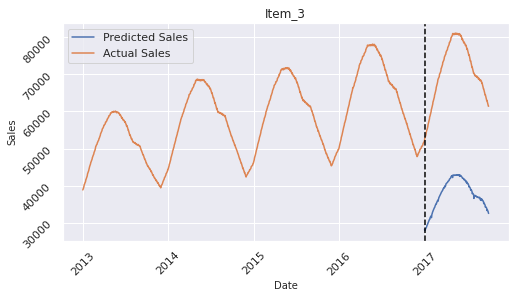

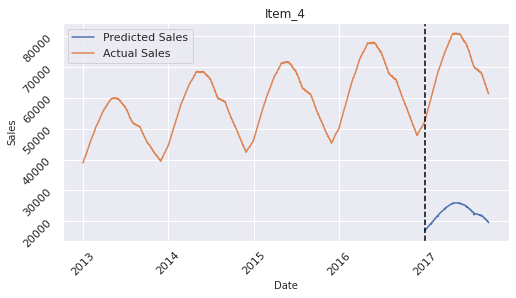

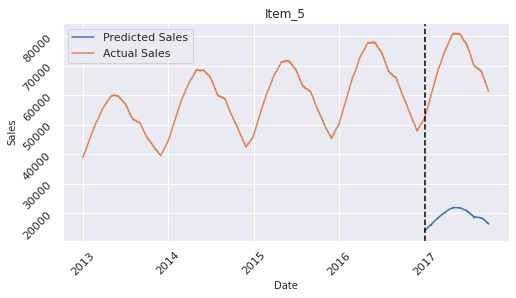

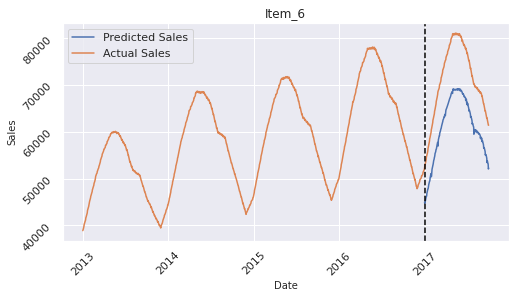

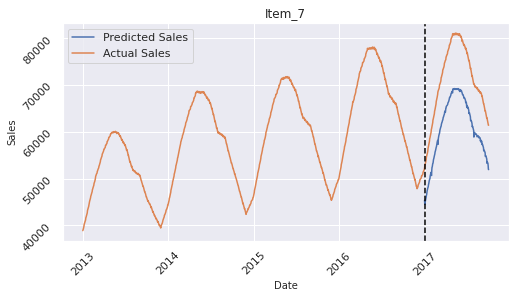

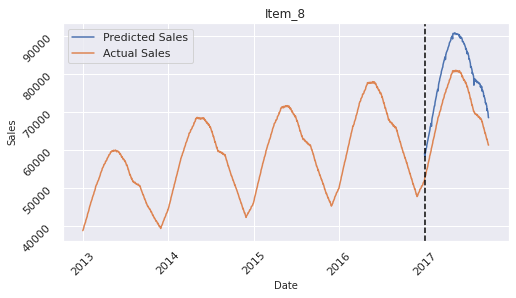

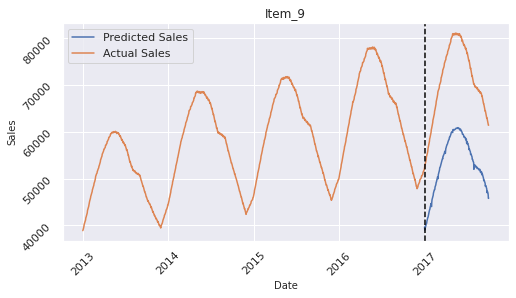

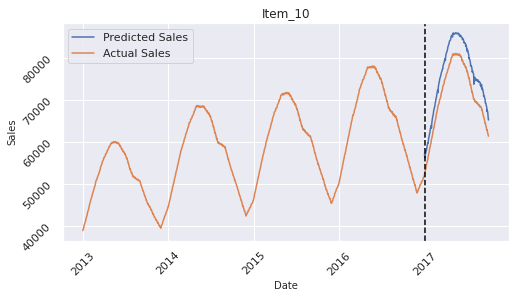

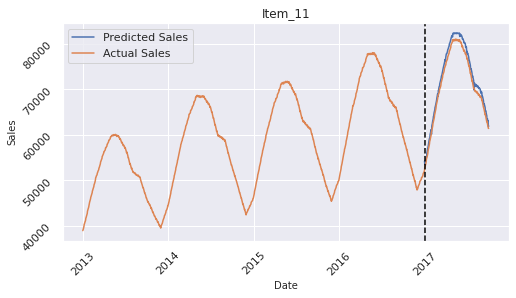

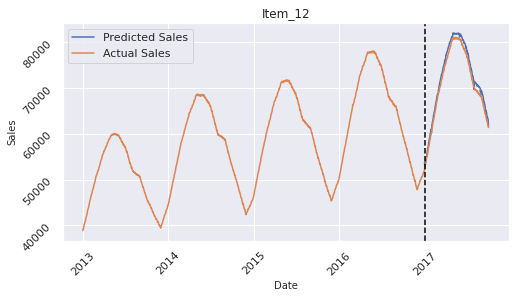

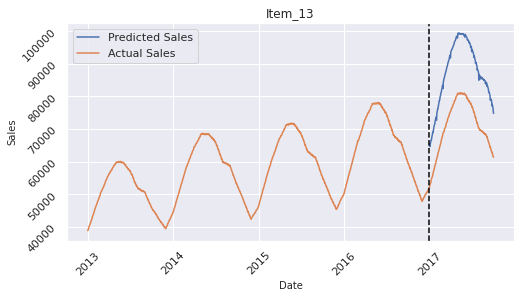

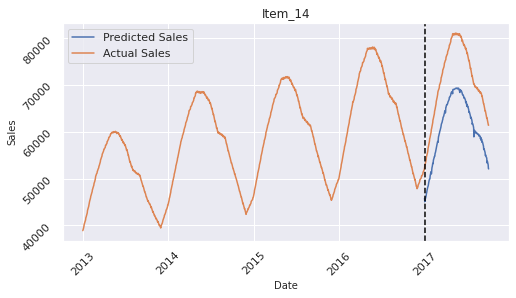

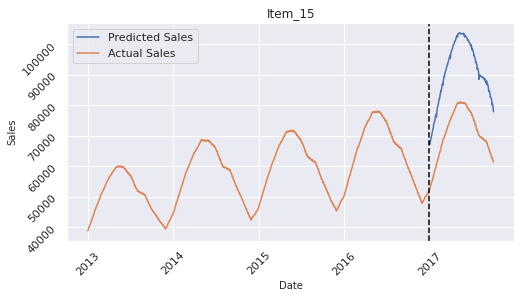

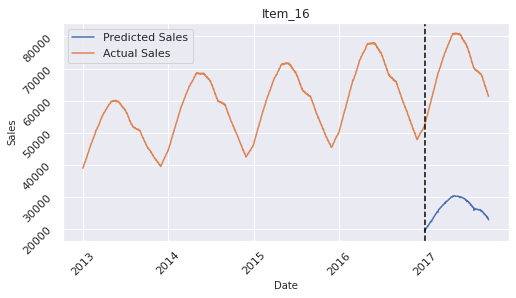

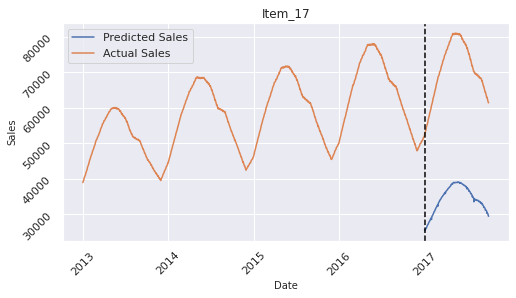

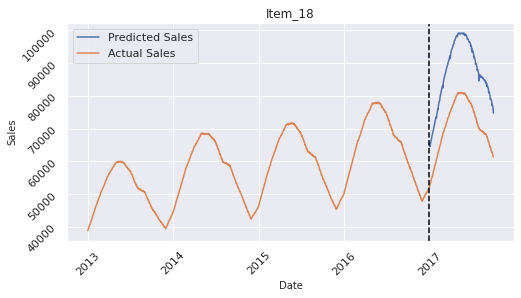

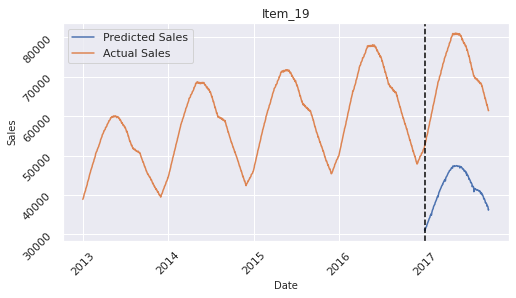

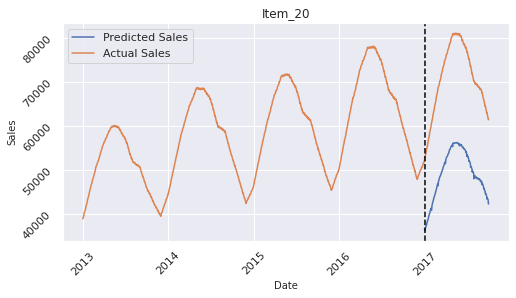

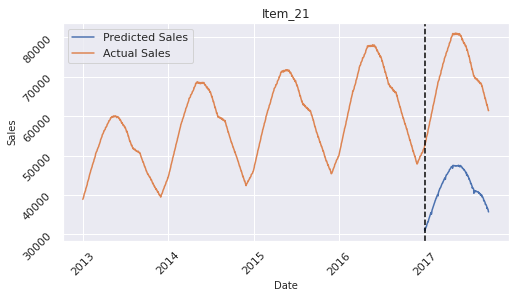

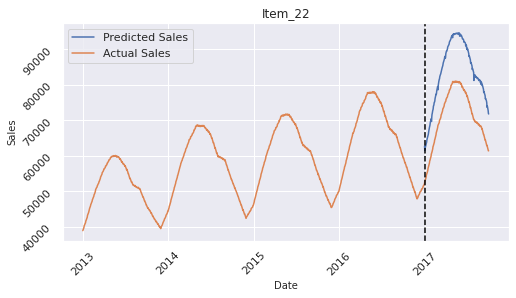

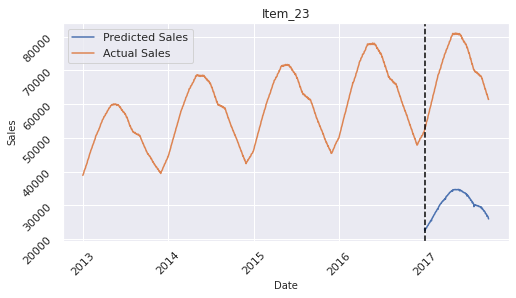

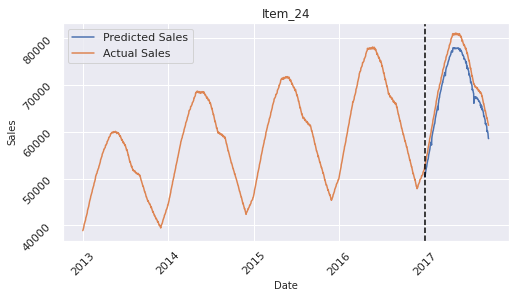

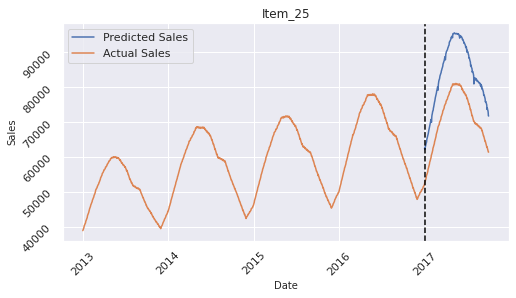

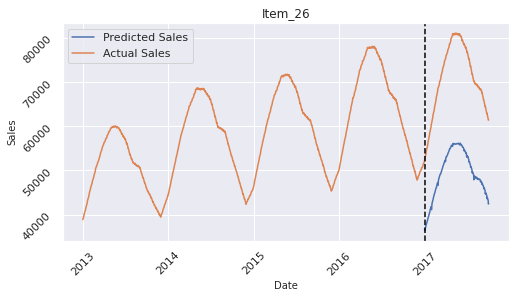

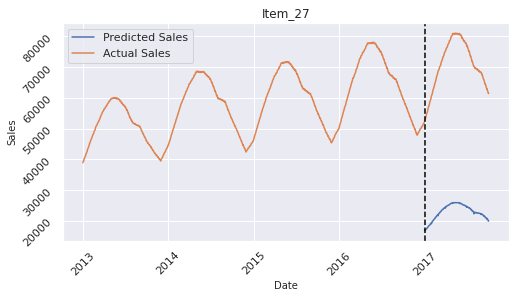

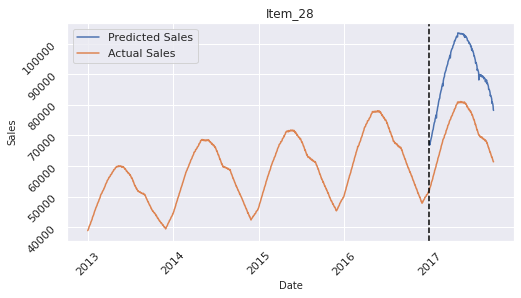

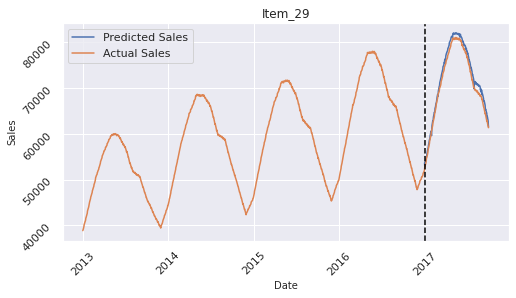

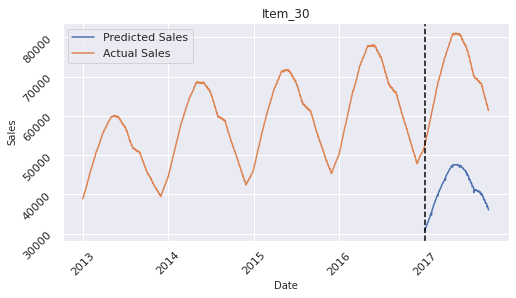

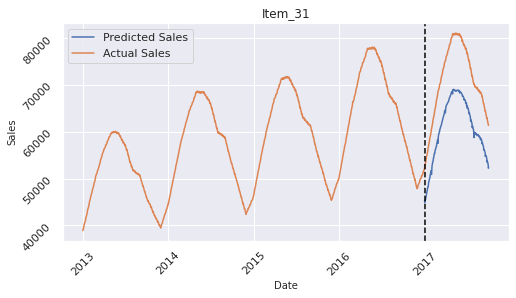

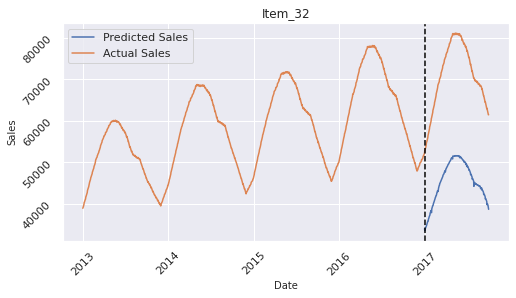

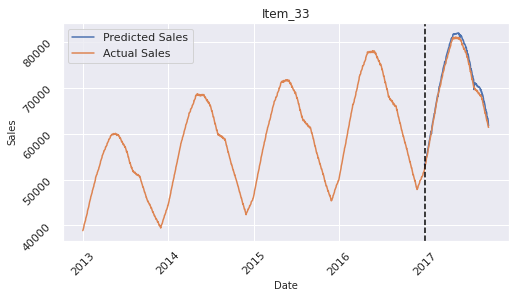

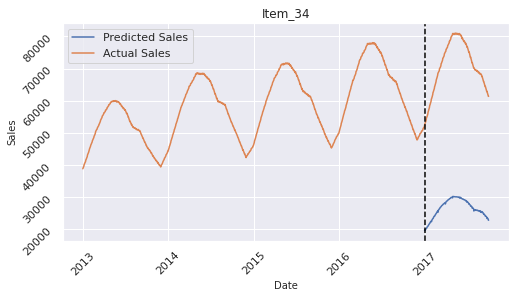

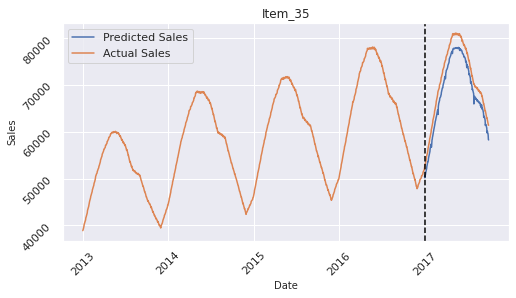

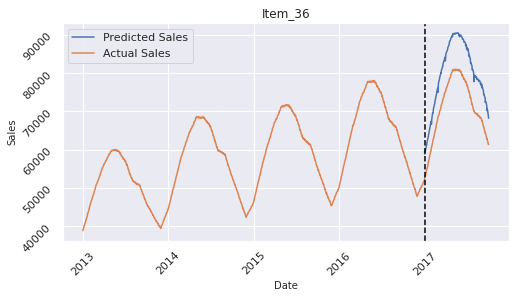

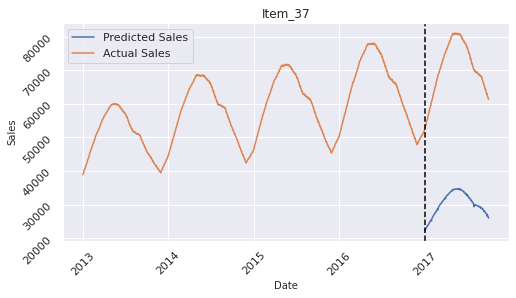

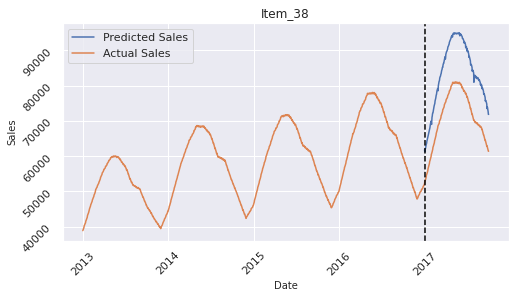

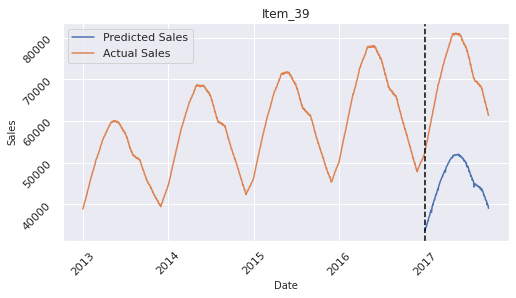

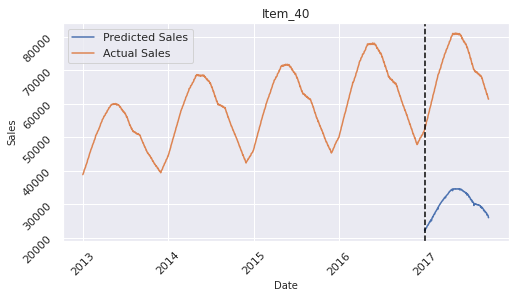

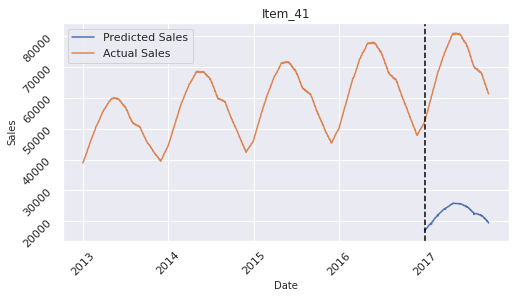

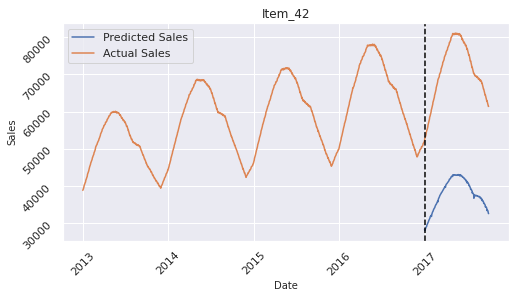

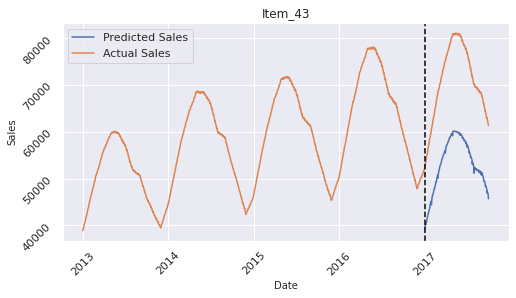

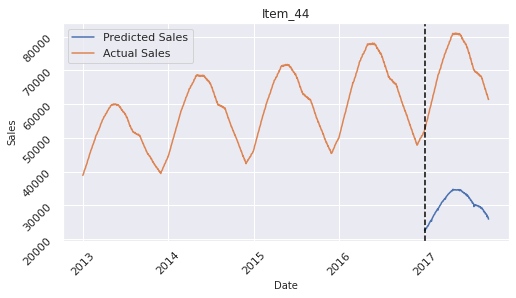

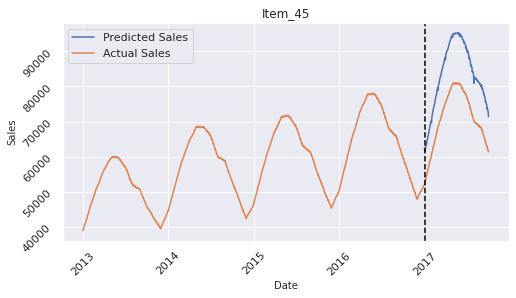

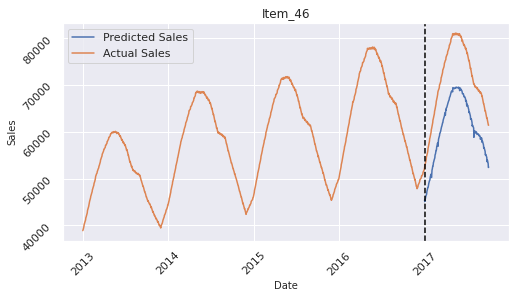

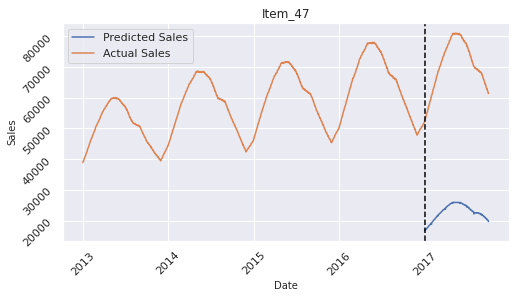

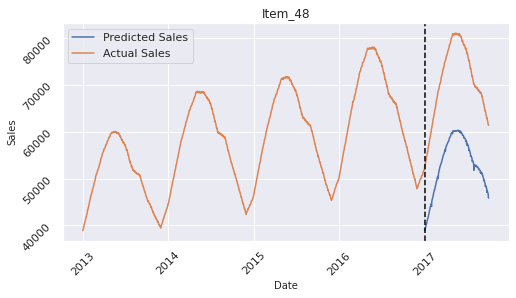

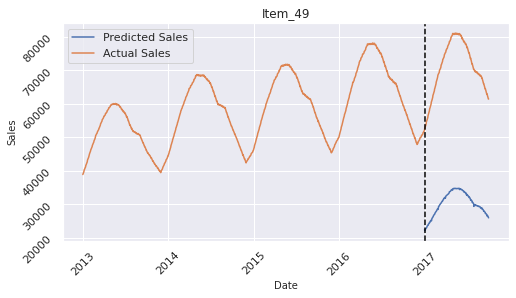

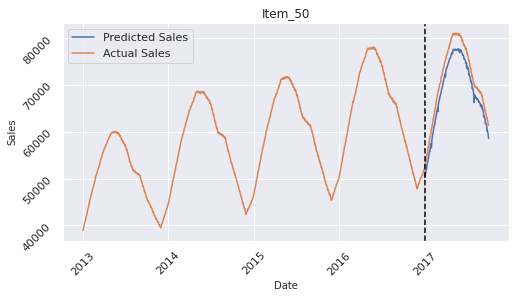

In [ ]:
#Visualizing the predicted and Actual sales

for k,v in test_forecast_dict_rf.items():
  plotdf_rf = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-02'))
  fig, ax = plt.subplots(figsize=(8,4))
  plt.title('{}'.format(k))
  plt.plot(plotdf_rf, label='Predicted Sales')
  plt.plot(split_data_rf.sales, label='Actual Sales')
  plt.xlabel('Date', size=10)
  plt.ylabel('Sales', size=10)
  plt.xticks(rotation=45)
  plt.yticks(rotation=45)
  ax.axvline(pd.to_datetime('2017-01-01'), color='black', ls='--')  # convert date string to datetime object
  plt.legend(loc='best')
  plt.show()

**Feature Importance**

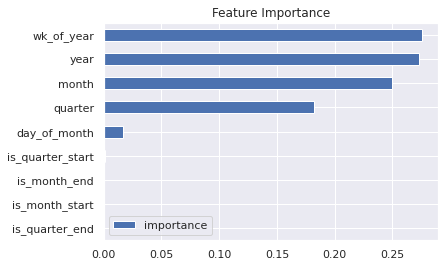

In [ ]:
feature_importance_rf = pd.DataFrame(data=rf_model.feature_importances_,
             index=rf_model.feature_names_in_,
             columns=['importance'])
feature_importance_rf.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
#creating dataframe for evaluation metrics for all 50 items
em_dict_rf_df = pd.DataFrame(em_dict_rf)

for i in em_dict_rf_df.columns:
  em_dict_rf_df[i] = em_dict_rf_df[i].apply(lambda x:round(x,2))
em_dict_rf_df.T

r2          MSE     RMSE      MAE  MAPE
Item_1   0.88    792256.88   890.09   868.10  0.04
Item_2   0.85   6908877.35  2628.47  2566.77  0.04
Item_3   0.82   3265808.65  1807.15  1786.61  0.05
Item_4   0.89    736820.11   858.38   832.65  0.03
Item_5   0.88    523200.83   723.33   715.45  0.04
Item_6   0.89   5175969.15  2275.08  2215.84  0.04
Item_7   0.88   5608661.19  2368.26  2333.65  0.04
Item_8   0.84  13114940.46  3621.46  3591.33  0.04
Item_9   0.86   4595171.24  2143.64  2080.94  0.04
Item_10  0.83  12038178.49  3469.61  3435.37  0.04
Item_11  0.87   8918133.41  2986.32  2945.57  0.04
Item_12  0.86   9513039.75  3084.32  3054.34  0.04
Item_13  0.85  14548287.72  3814.22  3772.08  0.04
Item_14  0.87   5970302.57  2443.42  2413.19  0.04
Item_15  0.86  14313454.19  3783.31  3738.16  0.04
Item_16  0.85   1308422.61  1143.86  1124.43  0.04
Item_17  0.91   1347876.27  1160.98  1141.56  0.03
Item_18  0.85  14927496.03  3863.61  3798.83  0.04
Item_19  0.83   3658666.28  1912.76  1878.57  0.04
Item_20  0.86   4110927.55  2027.54  2009.28  0.04
Item_21  0.86   2989326.19  1728.97  1695.77  0.04
Item_22  0.87  10899217.11  3301.40  3265.74  0.04
Item_23  0.87   1508416.35  1228.18  1215.38  0.04
Item_24  0.87   7496172.52  2737.91  2713.22  0.04
Item_25  0.88  10379321.64  3221.70  3172.10  0.04
Item_26  0.85   4314577.64  2077.16  2058.31  0.04
Item_27  0.88    900664.66   949.03   884.41  0.04
Item_28  0.85  14966481.36  3868.65  3829.67  0.04
Item_29  0.84  10098267.11  3177.78  3145.46  0.04
Item_30  0.85   3300395.19  1816.70  1791.42  0.04
Item_31  0.86   6119666.99  2473.80  2435.83  0.04
Item_32  0.80   5549376.20  2355.71  2322.95  0.05
Item_33  0.83  11293183.30  3360.53  3318.25  0.04
Item_34  0.85   1330236.57  1153.36  1125.45  0.04
Item_35  0.85   8290580.15  2879.34  2850.68  0.04
Item_36  0.87  10323955.84  3213.09  3171.56  0.04
Item_37  0.85   1729156.51  1314.97  1301.41  0.04
Item_38  0.86  12479569.68  3532.64  3499.67  0.04
Item_39  0.87   3332586.08  1825.54  1801.80  0.04
Item_40  0.87   1608765.92  1268.37  1253.83  0.04
Item_41  0.85   1069035.01  1033.94   986.03  0.04
Item_42  0.88   2144810.43  1464.52  1445.42  0.04
Item_43  0.82   6242280.02  2498.46  2460.75  0.04
Item_44  0.86   1640548.83  1280.84  1262.17  0.04
Item_45  0.84  14179552.12  3765.57  3738.32  0.04
Item_46  0.88   5672273.77  2381.65  2342.66  0.04
Item_47  0.83   1188821.90  1090.33  1049.93  0.04
Item_48  0.83   5796801.82  2407.65  2377.17  0.04
Item_49  0.81   2159624.78  1469.57  1454.24  0.05
Item_50  0.88   7525544.01  2743.27  2700.27  0.04

## **XGBoost**

In [ ]:
# dictionary for collecting the test data forecast results
test_forecast_dict_xgb = dict()

# dictionary for collecting the evaluation metrics of the test forecast
em_dict_xgb = dict()

In [ ]:
# running a for loop for every 50 items
for i in list(df_agg['item'].unique()):

  # filtering the data item-wise
  data = df_agg[df_agg['item']==i].drop(['item'], axis=1)
  
  # Splitting the dataset into dependent and independent variable
  x = data.drop(['sales'], axis=1)
  y = data['sales']
   
  #since it is a time series dataset we should split the train and test data 
  #Taking 2013 to 2016 data as train data
  #Taking 2017 data as test data
  x_train = x.loc[:'2016-12-31']
  x_test = x.loc['2017-01-01':'2017-10-02'] 
  y_train = y.loc[:'2016-12-31']
  y_test = y.loc['2017-01-01':'2017-10-02']

  # Initialize the model
  xgbr = XGB(verbosity=0,learning_rate = 0.5, n_estimators=100)

  # Fitting the the model
  xgbr.fit(x_train, y_train)

  # predicting the x-test data
  y_pred = xgbr.predict(x_test)
  
  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i)
  v = y_pred

  # dictionary for test data
  test_forecast_dict_xgb.update({k:v})

  # Evaluation Metrics
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # creating a key and value for test_forecast evaluation metrics dictionary
  key = 'Item_'+str(i)
  value = {'r2':r2, 'MSE':mse, 'RMSE':rmse, 'MAE':mae, 'MAPE':mape}
  em_dict_xgb.update({key:value})


In [ ]:
# create a dataframe for test data prediction
test_forecast_dict_xgb_df = pd.DataFrame(test_forecast_dict_xgb, index=[pd.date_range(start='2017-01-01', end='2017-10-02')])
for i in test_forecast_dict_xgb_df.columns:
  test_forecast_dict_xgb_df[i] = test_forecast_dict_xgb_df[i].apply(lambda x:round(x,2))

test_forecast_dict_xgb_df

Item_1    Item_2    Item_3    Item_4    Item_5    Item_6  \
2017-01-01  16608.82  44920.87  27774.82  16832.32  13951.31  44462.40   
2017-01-02  16978.37  45652.91  28221.02  17072.49  14271.27  44535.87   
2017-01-03  16981.56  45727.52  28247.13  17171.01  14297.15  44598.46   
2017-01-04  16921.75  45746.82  28306.08  17203.43  14310.30  45411.84   
2017-01-05  16958.05  45880.16  28404.20  17277.84  14346.52  45555.41   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  20015.18  53960.66  33468.26  20052.85  16795.78  53741.93   
2017-09-29  19950.32  53754.32  33312.77  19959.96  16713.86  53546.27   
2017-09-30  19822.05  53449.73  33182.79  19878.76  16636.69  53323.26   
2017-10-01  19829.19  53272.78  33045.57  19830.84  16560.48  53103.77   
2017-10-02  19693.21  53161.27  32943.10  19791.47  16489.93  52785.84   

              Item_7    Item_8    Item_9   Item_10  ...   Item_41   Item_42  \
2017-01-01  44383.04  58378.64  38807.21  55979.71  ...  16898.07  27927.80   
2017-01-02  45751.61  58582.95  39457.88  56840.73  ...  17267.49  28772.62   
2017-01-03  45567.25  58891.29  39568.75  57065.37  ...  17281.36  28763.88   
2017-01-04  45423.86  59558.96  39651.42  57131.29  ...  17258.86  28633.46   
2017-01-05  45501.56  59715.41  39807.59  57377.07  ...  17305.78  28700.71   
...              ...       ...       ...       ...  ...       ...       ...   
2017-09-28  53522.76  70720.90  47190.98  67354.84  ...  20024.30  33564.50   
2017-09-29  53273.62  70290.16  47009.79  67064.09  ...  19959.26  33480.42   
2017-09-30  53029.17  70089.48  46789.31  66745.44  ...  19840.51  33268.39   
2017-10-01  52817.50  69787.79  46627.43  66529.36  ...  19764.44  33167.90   
2017-10-02  52427.50  69468.00  46374.57  66369.98  ...  19695.85  32927.42   

             Item_43   Item_44   Item_45   Item_46   Item_47   Item_48  \
2017-01-01  39318.05  22409.38  61127.23  44915.75  16692.11  38736.43   
2017-01-02  39972.66  22852.06  62129.27  45595.07  17024.70  39311.03   
2017-01-03  40071.60  22868.44  62232.14  45630.34  17019.32  39452.22   
2017-01-04  40020.63  22866.94  62392.36  45792.11  17038.00  39529.74   
2017-01-05  40088.06  22935.40  62611.12  45967.43  17069.91  39654.55   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  47110.26  26755.76  73683.89  53848.52  20262.44  47184.87   
2017-09-29  46891.11  26637.24  73466.55  53708.50  20227.90  47029.86   
2017-09-30  46703.54  26471.30  73083.46  53466.43  20107.92  46767.05   
2017-10-01  46562.72  26429.27  72859.21  53272.45  20071.60  46643.93   
2017-10-02  46458.43  26365.89  72582.02  53137.20  19991.06  46432.48   

             Item_49   Item_50  
2017-01-01  22018.17  50071.34  
2017-01-02  22273.85  50976.73  
2017-01-03  22417.68  51077.09  
2017-01-04  22525.56  51078.80  
2017-01-05  22635.24  51193.11  
...              ...       ...  
2017-09-28  26607.92  60240.98  
2017-09-29  26532.28  60067.60  
2017-09-30  26448.25  59769.72  
2017-10-01  26379.39  59624.63  
2017-10-02  26254.81  59513.01  

[275 rows x 50 columns]

In [ ]:
# Dictionary for performance evaluation metrics
em_dict_xgb_df = pd.DataFrame(em_dict_xgb)


for i in em_dict_xgb_df.columns:
  em_dict_xgb_df[i] = em_dict_xgb_df[i].apply(lambda x:round(x,2))

em_dict_xgb_df.T

r2          MSE     RMSE      MAE  MAPE
Item_1   0.90    652282.93   807.64   776.70  0.03
Item_2   0.88   5793374.09  2406.94  2335.60  0.04
Item_3   0.85   2721176.00  1649.60  1625.53  0.04
Item_4   0.91    610240.91   781.18   751.83  0.03
Item_5   0.91    416763.86   645.57   637.92  0.03
Item_6   0.91   4187235.19  2046.27  1989.63  0.03
Item_7   0.90   4672683.52  2161.64  2117.93  0.03
Item_8   0.86  11158118.20  3340.38  3305.05  0.04
Item_9   0.88   3821318.25  1954.82  1902.92  0.04
Item_10  0.85  10118667.19  3180.99  3151.49  0.04
Item_11  0.89   7647745.84  2765.46  2717.92  0.04
Item_12  0.88   8067464.38  2840.33  2809.54  0.04
Item_13  0.88  11907470.45  3450.72  3410.82  0.04
Item_14  0.89   5116213.66  2261.90  2218.01  0.04
Item_15  0.89  11960065.18  3458.33  3393.84  0.04
Item_16  0.87   1077574.87  1038.06  1017.77  0.04
Item_17  0.93   1084971.54  1041.62  1020.66  0.03
Item_18  0.88  12597372.03  3549.28  3468.52  0.04
Item_19  0.86   3129264.28  1768.97  1734.90  0.04
Item_20  0.88   3461620.69  1860.54  1843.62  0.04
Item_21  0.89   2504198.81  1582.47  1536.85  0.04
Item_22  0.89   8903557.01  2983.88  2930.04  0.03
Item_23  0.89   1267400.47  1125.79  1113.39  0.04
Item_24  0.89   6168132.59  2483.57  2460.10  0.03
Item_25  0.91   8524059.85  2919.60  2853.18  0.03
Item_26  0.88   3572865.15  1890.20  1871.79  0.04
Item_27  0.90    762328.68   873.11   796.24  0.03
Item_28  0.88  12542057.62  3541.48  3496.23  0.04
Item_29  0.87   8295740.47  2880.23  2852.99  0.04
Item_30  0.88   2739354.40  1655.10  1628.18  0.04
Item_31  0.88   5157070.22  2270.92  2228.44  0.04
Item_32  0.82   4819949.96  2195.44  2156.37  0.04
Item_33  0.86   9740518.51  3120.98  3076.09  0.04
Item_34  0.87   1144254.26  1069.70  1032.92  0.04
Item_35  0.88   6866132.47  2620.33  2602.17  0.04
Item_36  0.89   8574638.99  2928.25  2884.01  0.03
Item_37  0.87   1448127.26  1203.38  1189.80  0.04
Item_38  0.88  10347615.63  3216.77  3185.15  0.04
Item_39  0.89   2778953.56  1667.02  1635.33  0.03
Item_40  0.89   1316267.11  1147.29  1131.84  0.04
Item_41  0.87    932226.64   965.52   906.80  0.04
Item_42  0.90   1782089.55  1334.95  1316.28  0.03
Item_43  0.85   5296092.97  2301.32  2257.73  0.04
Item_44  0.88   1361521.12  1166.84  1146.26  0.04
Item_45  0.86  11965588.37  3459.13  3428.30  0.04
Item_46  0.90   4729873.38  2174.83  2137.18  0.03
Item_47  0.85   1017033.04  1008.48   967.06  0.04
Item_48  0.85   4857231.47  2203.91  2180.37  0.04
Item_49  0.84   1840491.63  1356.65  1345.21  0.04
Item_50  0.90   6099029.59  2469.62  2426.37  0.03

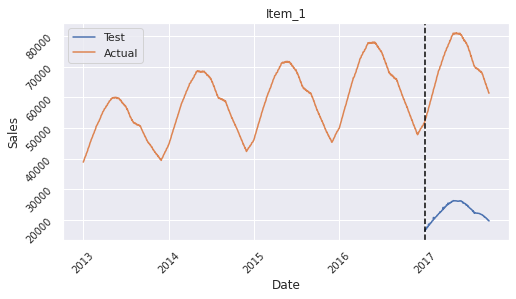

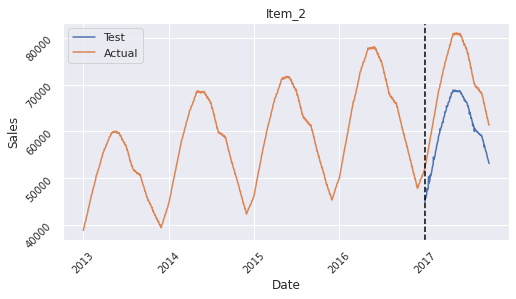

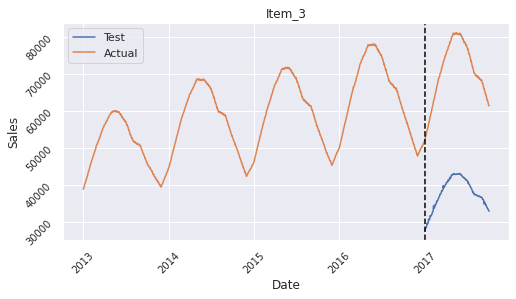

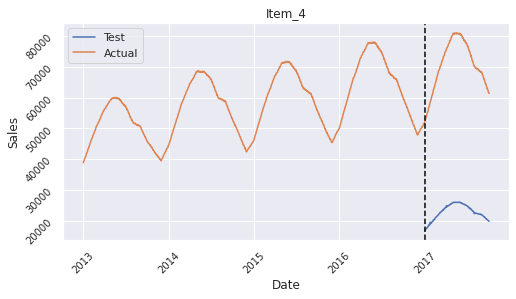

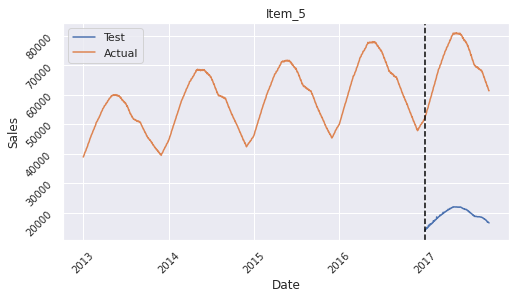

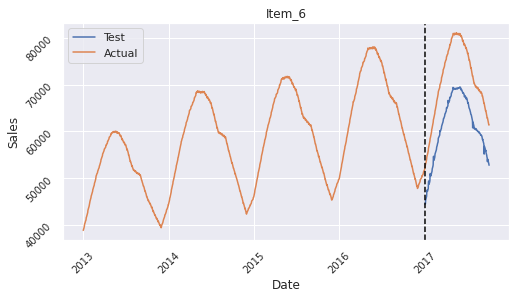

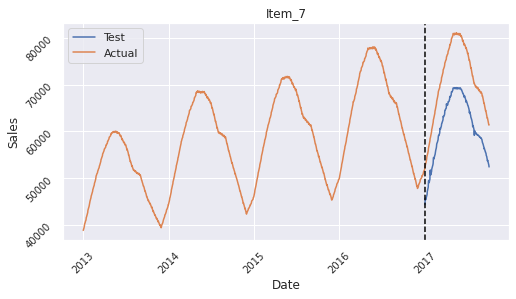

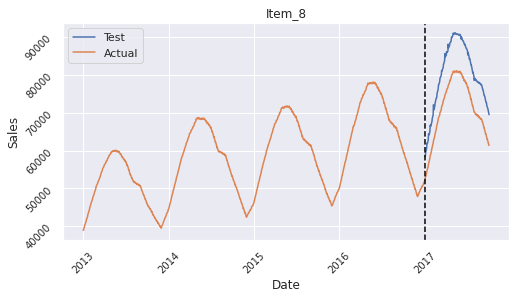

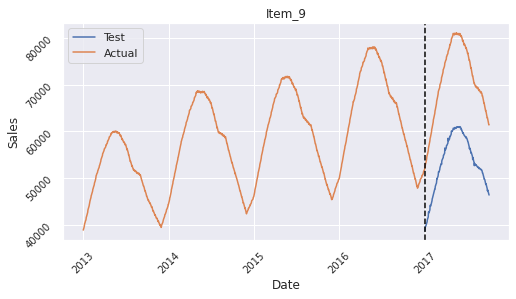

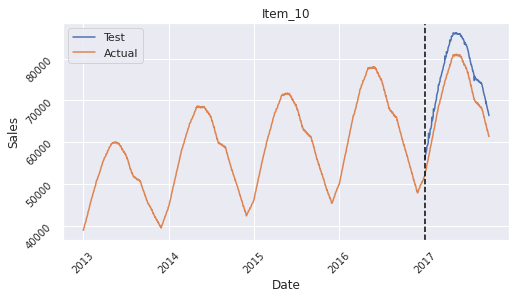

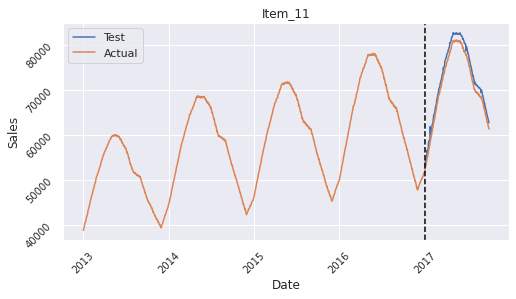

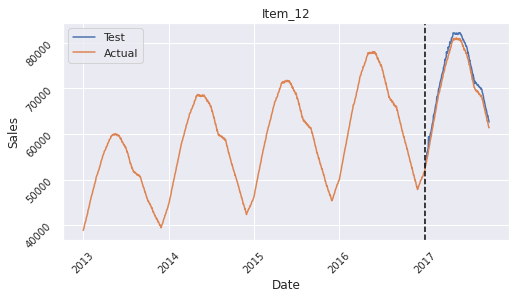

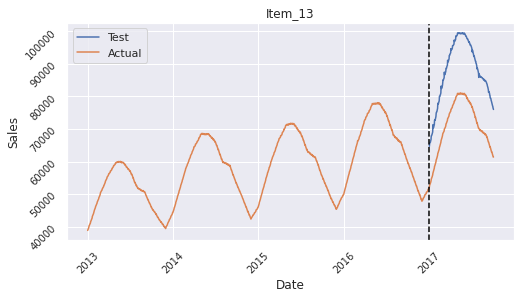

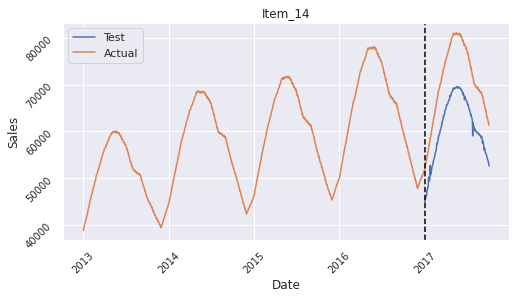

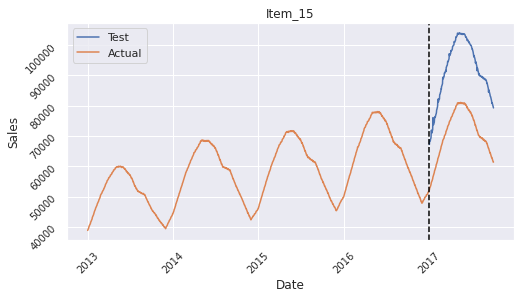

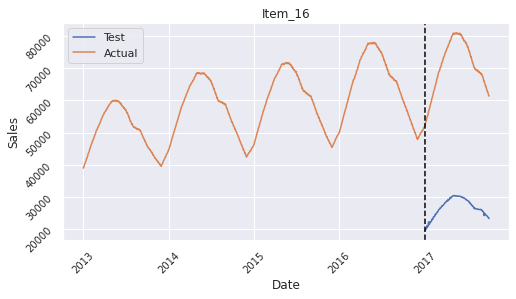

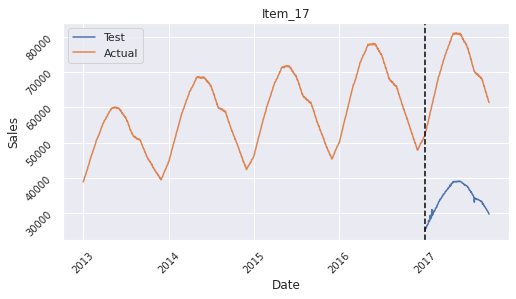

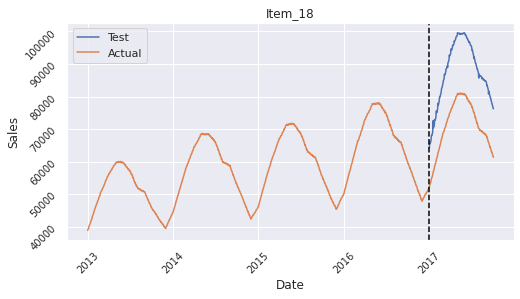

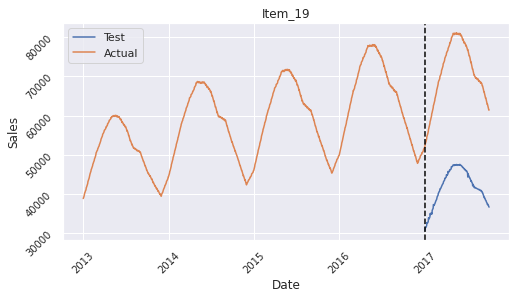

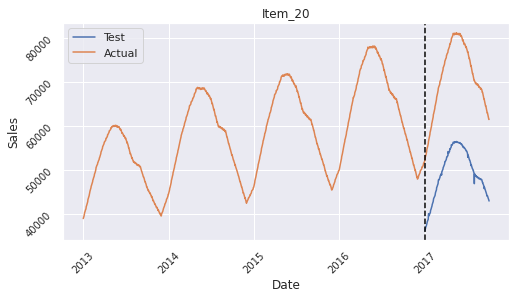

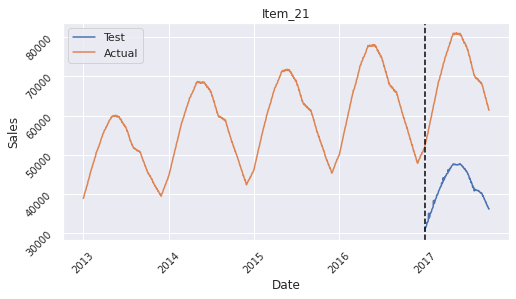

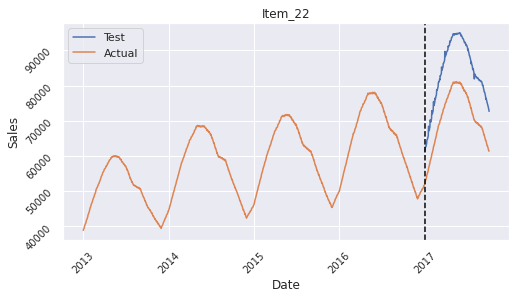

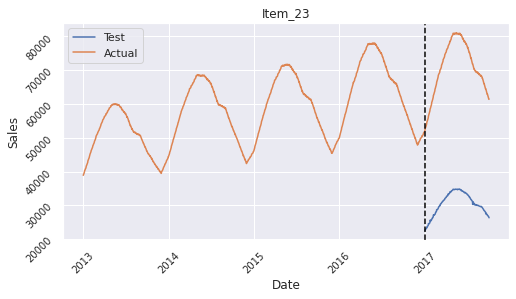

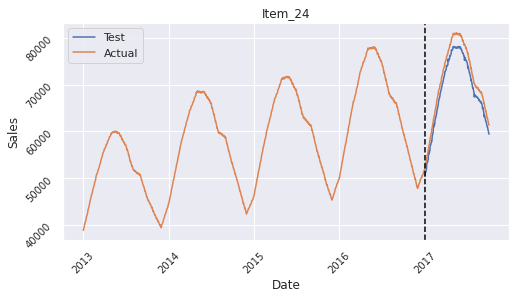

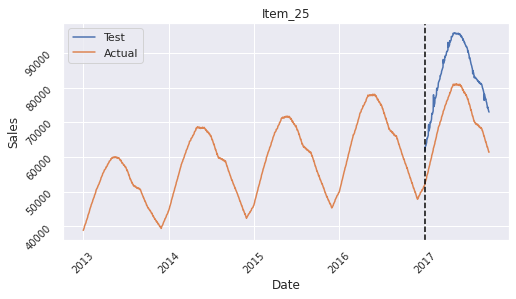

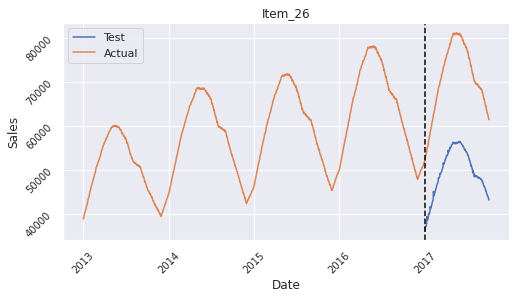

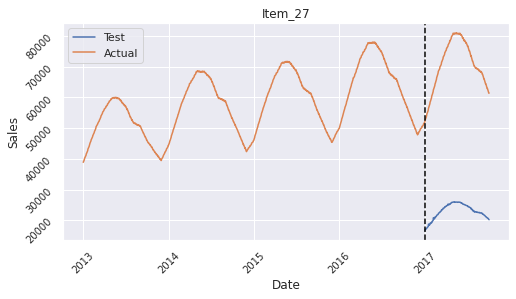

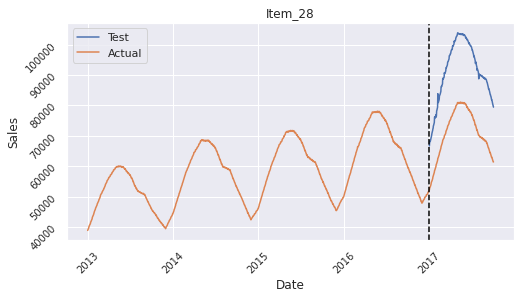

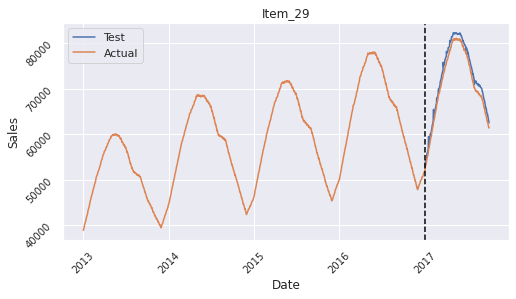

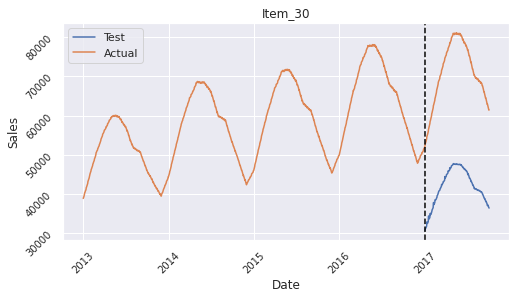

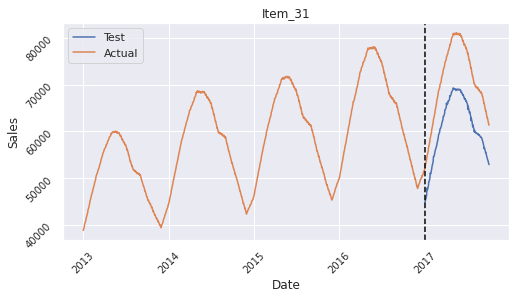

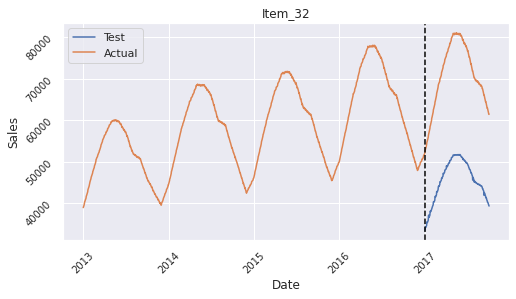

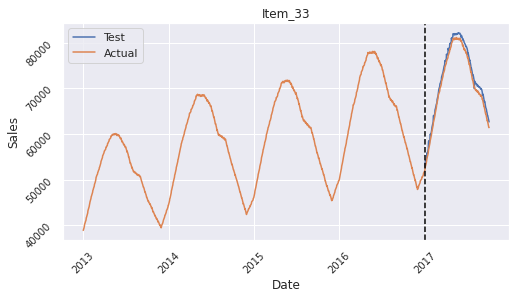

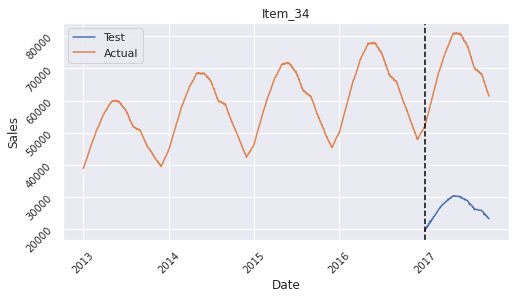

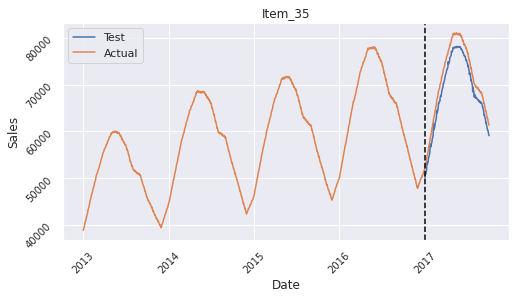

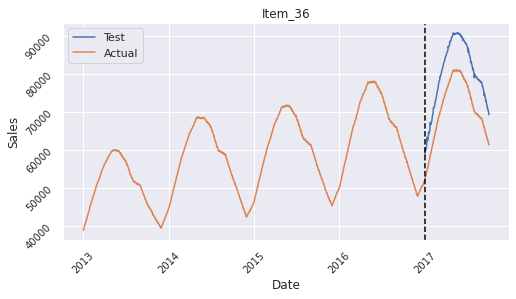

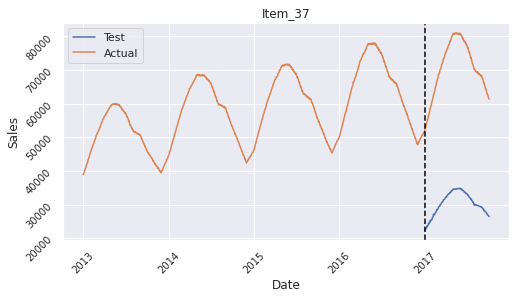

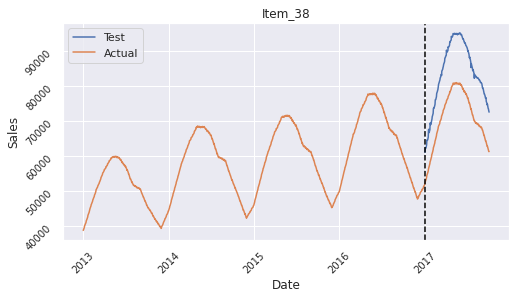

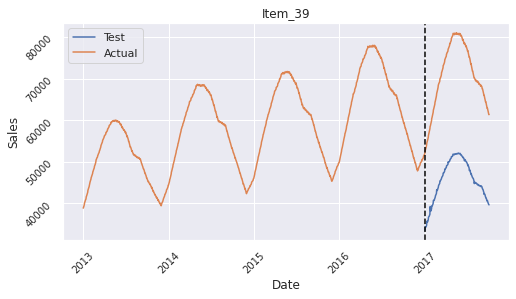

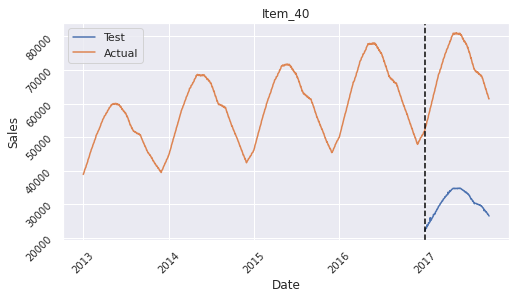

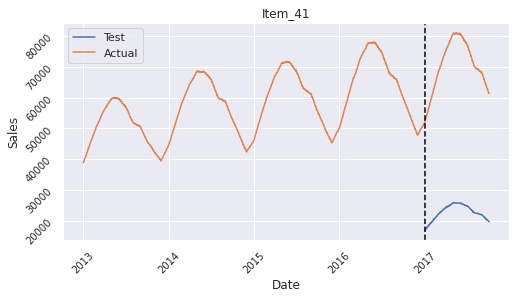

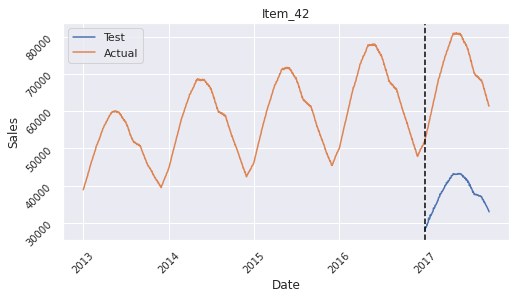

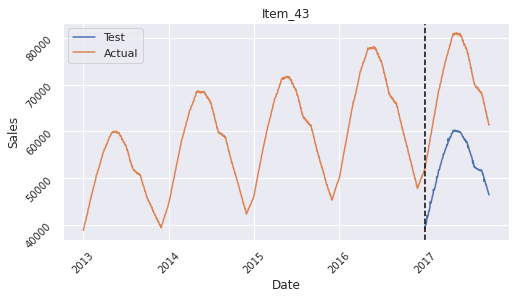

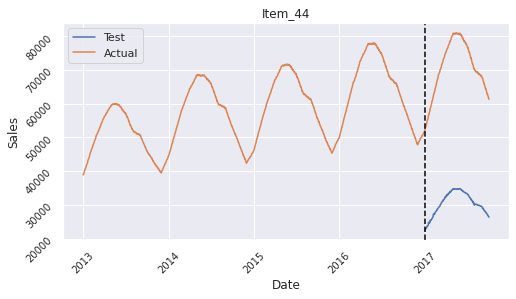

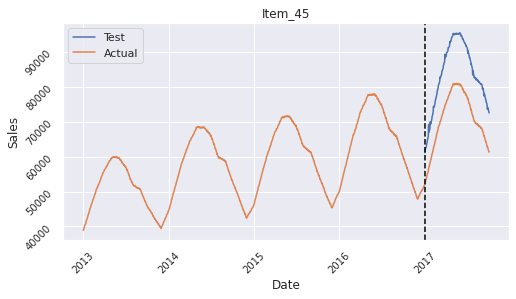

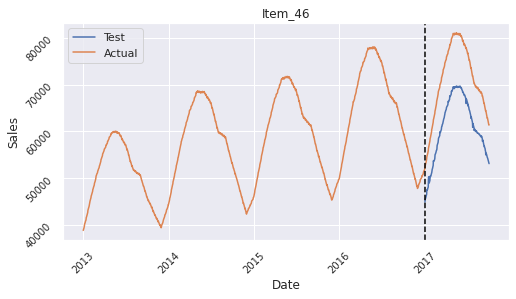

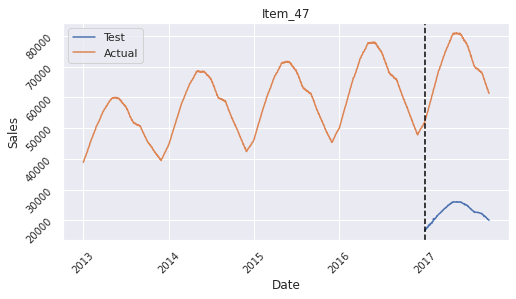

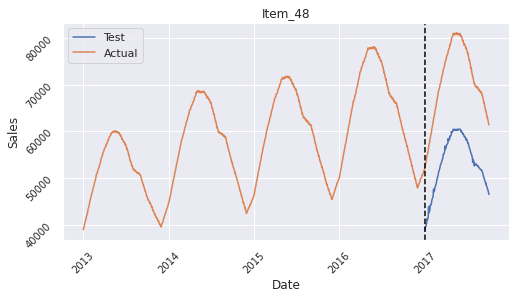

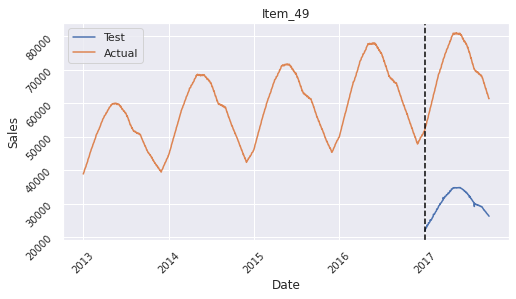

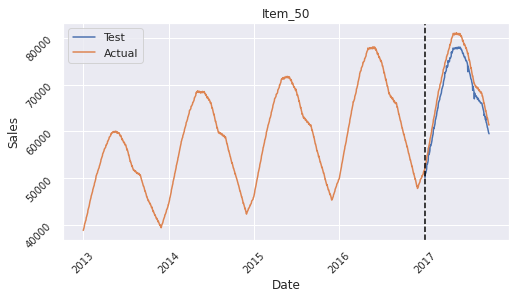

In [ ]:
# plotting forecast and actual sales

for k, v in test_forecast_dict_xgb.items():
  forecast = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-02'))
  fig, ax = plt.subplots(figsize=(8,4))
  plt.title(k)
  plt.plot(forecast, label='Test')
  plt.plot(data.sales, label='Actual')
  plt.xlabel('Date', size=12)
  plt.ylabel('Sales', size=12)
  plt.xticks(rotation=45, size=10)
  plt.yticks(rotation=45, size=10)
  ax.axvline(pd.to_datetime('2017-01-01'), color='black', ls='--')  # convert date string to datetime object
  plt.legend(loc='best')
  plt.show()

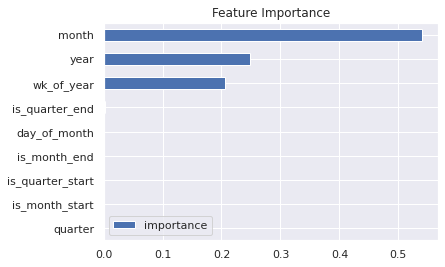

In [ ]:
feature_importance_xgb = pd.DataFrame(data=xgbr.feature_importances_,
             index=xgbr.feature_names_in_,
             columns=['importance'])
feature_importance_xgb.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## **Linear Regression**

In [ ]:
# dictionary for collecting the test data predicted results
test_forecast_dict_lr = dict()

# dictionary for collecting the evaluation metrics 
em_dict_lr = dict()
     

In [ ]:
df_agg_lr = df_agg.copy()
df_agg_lr

item    sales  day_of_month  month  year  wk_of_year  quarter  \
date                                                                        
2013-01-01     1  12848.0             1      1  2013           1        1   
2013-01-02     1  12936.0             2      1  2013           1        1   
2013-01-03     1  13019.0             3      1  2013           1        1   
2013-01-04     1  13103.0             4      1  2013           1        1   
2013-01-05     1  13153.0             5      1  2013           1        1   
...          ...      ...           ...    ...   ...         ...      ...   
2017-09-28    50  62200.0            28      9  2017          39        3   
2017-09-29    50  61962.0            29      9  2017          39        3   
2017-09-30    50  61687.0            30      9  2017          39        3   
2017-10-01    50  61392.0             1     10  2017          39        4   
2017-10-02    50  61395.0             2     10  2017          40        4   

            is_month_start  is_month_end  is_quarter_start  is_quarter_end  
date                                                                        
2013-01-01               1             0                 1               0  
2013-01-02               0             0                 0               0  
2013-01-03               0             0                 0               0  
2013-01-04               0             0                 0               0  
2013-01-05               0             0                 0               0  
...                    ...           ...               ...             ...  
2017-09-28               0             0                 0               0  
2017-09-29               0             0                 0               0  
2017-09-30               0             1                 0               1  
2017-10-01               1             0                 1               0  
2017-10-02               0             0                 0               0  

[86849 rows x 11 columns]

In [ ]:
# running a for loop with a list of unique items in the dataset as the iterable
for i in list(df_agg_lr['item'].unique()):

  #filtering the data item_wise
  data = df_agg_lr[df_agg_lr['item']==i].drop(['item'], axis=1)
  
  #Splitting the dataset into dependent and independent variable
  x = data.drop(['sales'], axis=1)
  y = data['sales']

  #since it is a time series dataset we should split the train and test data 
  #Taking 2013 to 2016 data as train data
  #Taking 2017 data as test data
  x_train = x.loc[:'2016-12-31']
  x_test = x.loc['2017-01-01':'2017-10-02'] 
  y_train = y.loc[:'2016-12-31']
  y_test = y.loc['2017-01-01':'2017-10-02']

  

  # Initialize the model
  regressor = LinearRegression()

  # Fitting the data to the model
  regressor.fit(x_train, y_train)


  # predicting the x-test data
  y_pred = xgbr.predict(x_test)
  
  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i)
  v = y_pred

  # dictionary for test data
  test_forecast_dict_lr.update({k:v})

  # Evaluation Metrics
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # creating a key and value for test_forecast evaluation metrics dictionary
  key = 'Item_'+str(i)
  value = {'r2':r2, 'MSE':mse, 'RMSE':rmse, 'MAE':mae, 'MAPE':mape}
  em_dict_lr.update({key:value})

In [ ]:
# Dataframe for test data forecast
test_forecast_dict_lr_df = pd.DataFrame(test_forecast_dict_lr, index=[pd.date_range(start='2017-01-01', end='2017-10-02')])

for i in test_forecast_dict_xgb_df.columns:
  test_forecast_dict_lr_df[i] = test_forecast_dict_lr_df[i].apply(lambda x:round(x,2))

test_forecast_dict_lr_df = test_forecast_dict_lr_df.reset_index()
test_forecast_dict_lr_df = test_forecast_dict_lr_df.set_index('level_0', drop=True)
test_forecast_dict_lr_df.index.name=None 
test_forecast_dict_lr_df   

Item_1    Item_2    Item_3    Item_4    Item_5    Item_6  \
2017-01-01  50071.34  50071.34  50071.34  50071.34  50071.34  50071.34   
2017-01-02  50976.73  50976.73  50976.73  50976.73  50976.73  50976.73   
2017-01-03  51077.09  51077.09  51077.09  51077.09  51077.09  51077.09   
2017-01-04  51078.80  51078.80  51078.80  51078.80  51078.80  51078.80   
2017-01-05  51193.11  51193.11  51193.11  51193.11  51193.11  51193.11   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  60240.98  60240.98  60240.98  60240.98  60240.98  60240.98   
2017-09-29  60067.60  60067.60  60067.60  60067.60  60067.60  60067.60   
2017-09-30  59769.72  59769.72  59769.72  59769.72  59769.72  59769.72   
2017-10-01  59624.63  59624.63  59624.63  59624.63  59624.63  59624.63   
2017-10-02  59513.01  59513.01  59513.01  59513.01  59513.01  59513.01   

              Item_7    Item_8    Item_9   Item_10  ...   Item_41   Item_42  \
2017-01-01  50071.34  50071.34  50071.34  50071.34  ...  50071.34  50071.34   
2017-01-02  50976.73  50976.73  50976.73  50976.73  ...  50976.73  50976.73   
2017-01-03  51077.09  51077.09  51077.09  51077.09  ...  51077.09  51077.09   
2017-01-04  51078.80  51078.80  51078.80  51078.80  ...  51078.80  51078.80   
2017-01-05  51193.11  51193.11  51193.11  51193.11  ...  51193.11  51193.11   
...              ...       ...       ...       ...  ...       ...       ...   
2017-09-28  60240.98  60240.98  60240.98  60240.98  ...  60240.98  60240.98   
2017-09-29  60067.60  60067.60  60067.60  60067.60  ...  60067.60  60067.60   
2017-09-30  59769.72  59769.72  59769.72  59769.72  ...  59769.72  59769.72   
2017-10-01  59624.63  59624.63  59624.63  59624.63  ...  59624.63  59624.63   
2017-10-02  59513.01  59513.01  59513.01  59513.01  ...  59513.01  59513.01   

             Item_43   Item_44   Item_45   Item_46   Item_47   Item_48  \
2017-01-01  50071.34  50071.34  50071.34  50071.34  50071.34  50071.34   
2017-01-02  50976.73  50976.73  50976.73  50976.73  50976.73  50976.73   
2017-01-03  51077.09  51077.09  51077.09  51077.09  51077.09  51077.09   
2017-01-04  51078.80  51078.80  51078.80  51078.80  51078.80  51078.80   
2017-01-05  51193.11  51193.11  51193.11  51193.11  51193.11  51193.11   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  60240.98  60240.98  60240.98  60240.98  60240.98  60240.98   
2017-09-29  60067.60  60067.60  60067.60  60067.60  60067.60  60067.60   
2017-09-30  59769.72  59769.72  59769.72  59769.72  59769.72  59769.72   
2017-10-01  59624.63  59624.63  59624.63  59624.63  59624.63  59624.63   
2017-10-02  59513.01  59513.01  59513.01  59513.01  59513.01  59513.01   

             Item_49   Item_50  
2017-01-01  50071.34  50071.34  
2017-01-02  50976.73  50976.73  
2017-01-03  51077.09  51077.09  
2017-01-04  51078.80  51078.80  
2017-01-05  51193.11  51193.11  
...              ...       ...  
2017-09-28  60240.98  60240.98  
2017-09-29  60067.60  60067.60  
2017-09-30  59769.72  59769.72  
2017-10-01  59624.63  59624.63  
2017-10-02  59513.01  59513.01  

[275 rows x 50 columns]

In [ ]:
# Dataframe for Evaluation metrics
em_dict_lr_df = pd.DataFrame(em_dict_lr)

for i in em_dict_xgb_df.columns:
  em_dict_lr_df[i] = em_dict_lr_df[i].apply(lambda x:round(x,2))

em_dict_lr_df

Item_1       Item_2        Item_3        Item_4        Item_5  \
r2   -2.995700e+02         0.38 -4.572000e+01 -2.991700e+02 -5.340200e+02   
MSE   2.033589e+09  28935590.08  8.488943e+08  2.040235e+09  2.397489e+09   
RMSE  4.509534e+04      5379.18  2.913579e+04  4.516896e+04  4.896416e+04   
MAE   4.483381e+04      5335.05  2.896013e+04  4.490822e+04  4.867237e+04   
MAPE  1.900000e+00         0.08  7.300000e-01  1.900000e+00  2.450000e+00   

           Item_6       Item_7        Item_8        Item_9       Item_10  ...  \
r2           0.32         0.35 -1.730000e+00 -4.380000e+00 -6.700000e-01  ...   
MSE   31275954.23  30726269.43  2.186807e+08  1.786979e+08  1.159337e+08  ...   
RMSE      5592.49      5543.13  1.478786e+04  1.336779e+04  1.076725e+04  ...   
MAE       5545.82      5502.54  1.470683e+04  1.325629e+04  1.072541e+04  ...   
MAPE         0.09         0.09  1.800000e-01  2.400000e-01  1.400000e-01  ...   

           Item_41       Item_42       Item_43       Item_44       Item_45  \
r2   -2.802800e+02 -4.864000e+01 -3.970000e+00 -1.154600e+02 -2.980000e+00   
MSE   2.023743e+09  8.593162e+08  1.736298e+08  1.373213e+09  3.512771e+08   
RMSE  4.498603e+04  2.931410e+04  1.317687e+04  3.705689e+04  1.874239e+04   
MAE   4.473247e+04  2.912833e+04  1.308345e+04  3.683761e+04  1.863735e+04   
MAPE  1.880000e+00  7.400000e-01  2.400000e-01  1.160000e+00  2.100000e-01   

          Item_46       Item_47       Item_48       Item_49     Item_50  
r2           0.37 -2.885200e+02 -4.200000e+00 -1.165200e+02        0.90  
MSE   29866639.05  2.020916e+09  1.739876e+08  1.369661e+09  6099029.59  
RMSE      5465.04  4.495460e+04  1.319043e+04  3.700893e+04     2469.62  
MAE       5425.02  4.469599e+04  1.308143e+04  3.678746e+04     2426.37  
MAPE         0.09  1.880000e+00  2.400000e-01  1.160000e+00        0.03  

[5 rows x 50 columns]

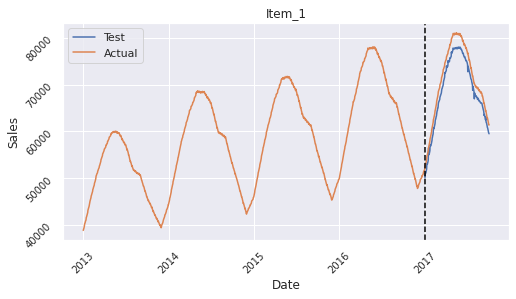

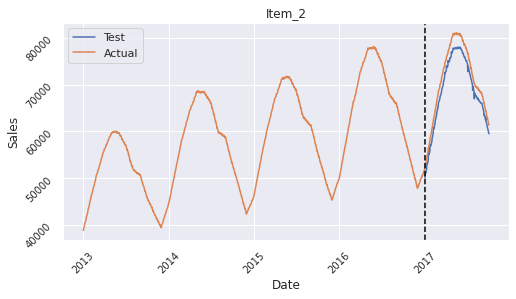

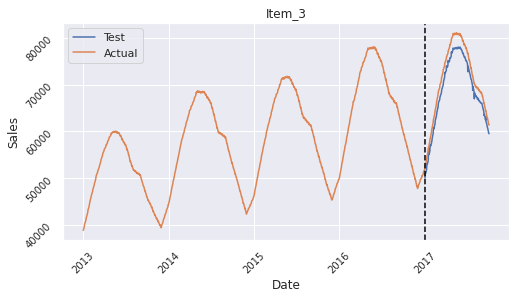

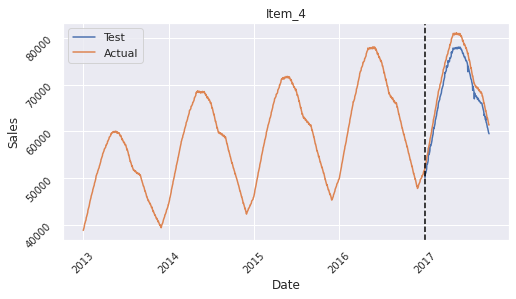

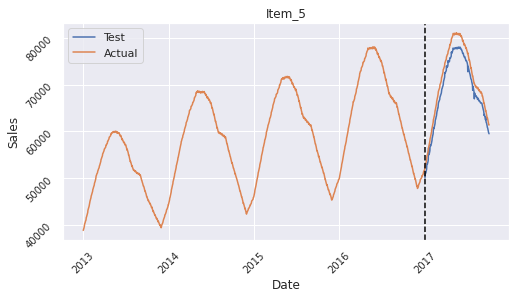

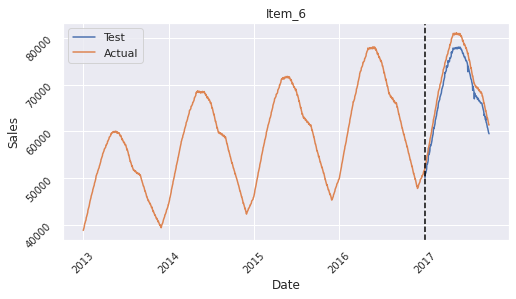

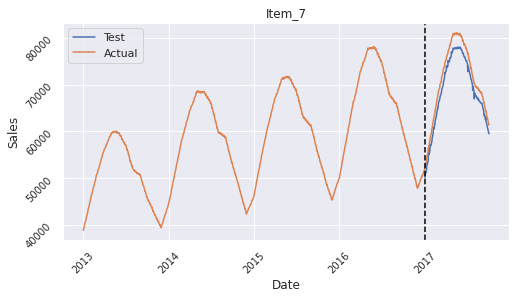

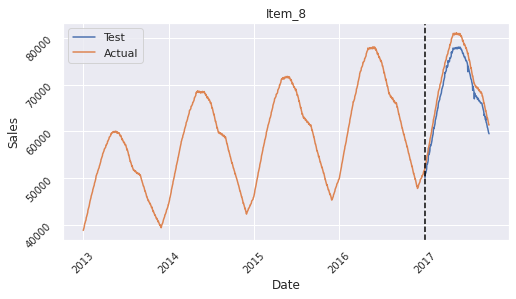

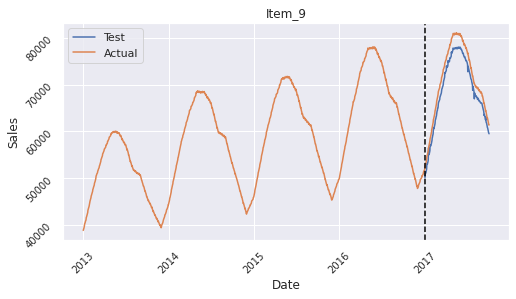

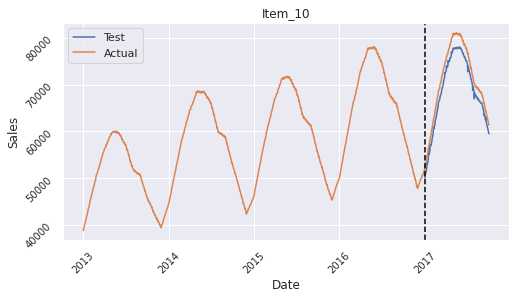

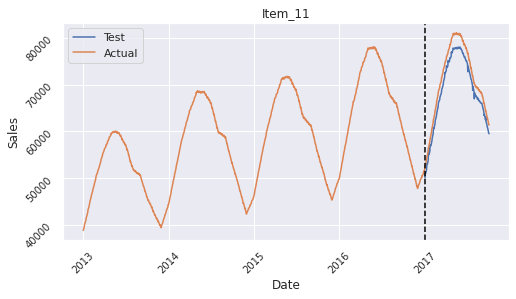

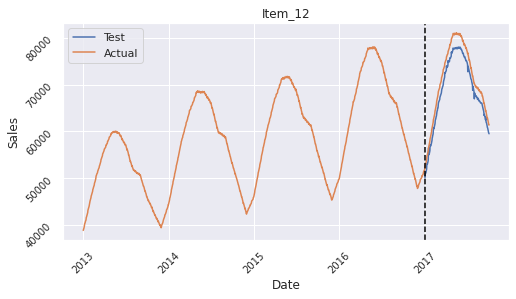

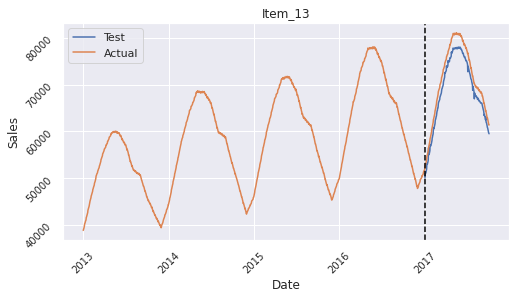

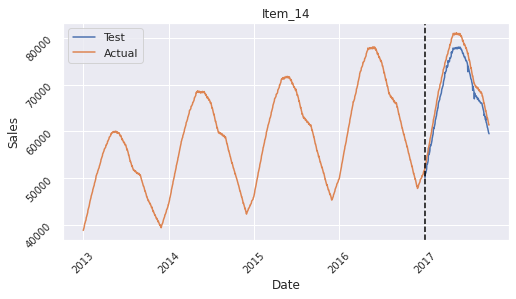

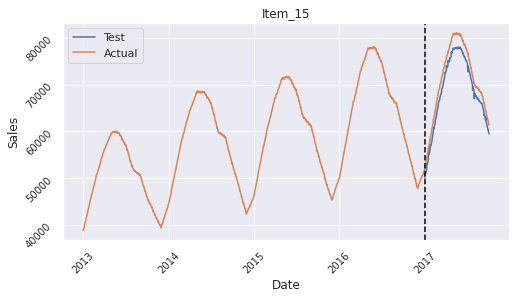

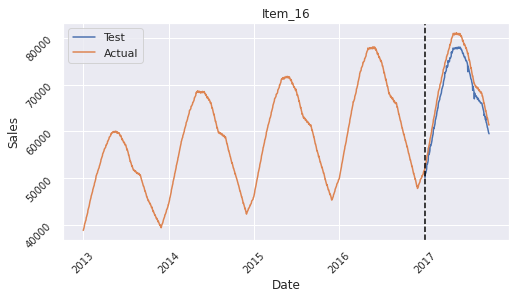

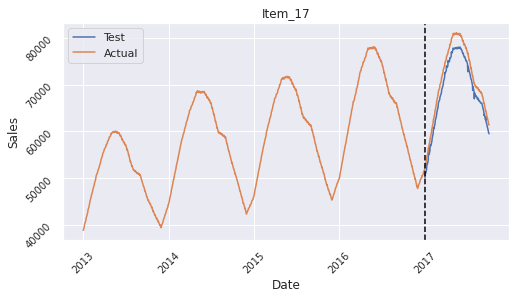

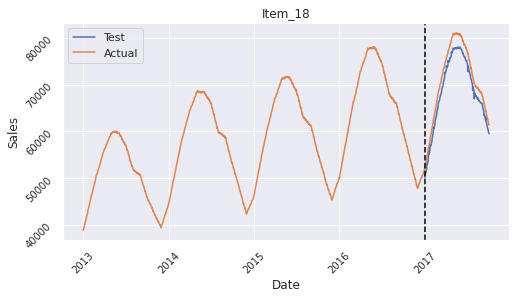

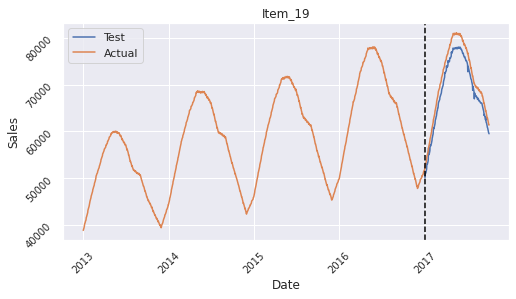

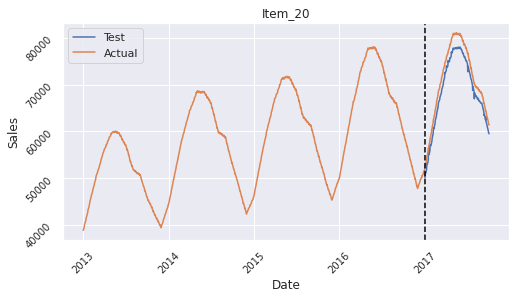

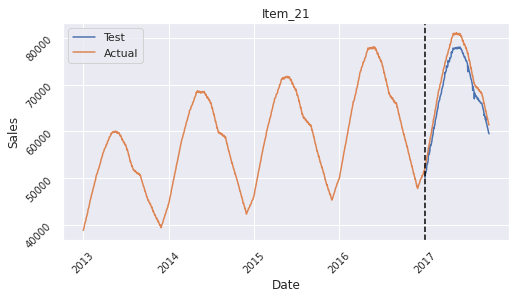

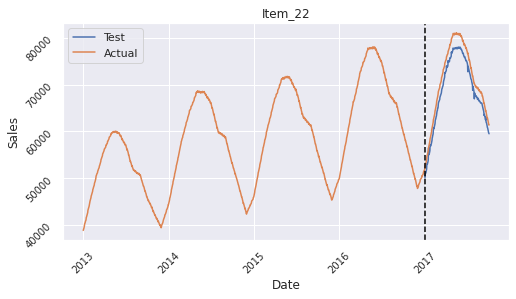

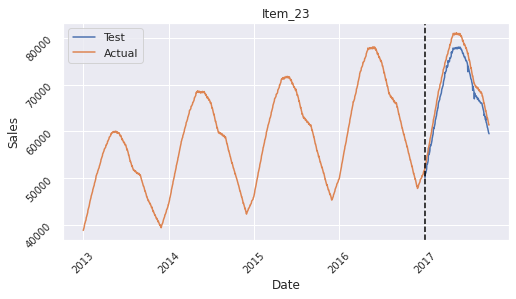

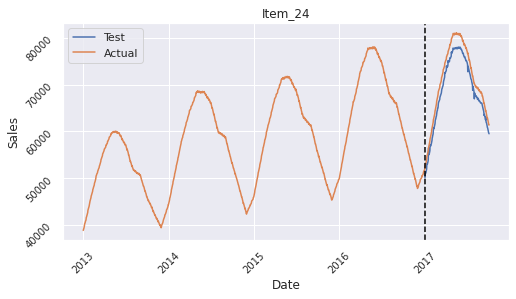

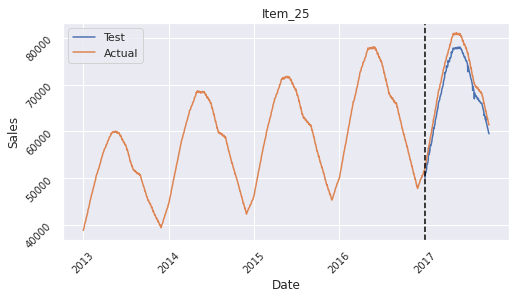

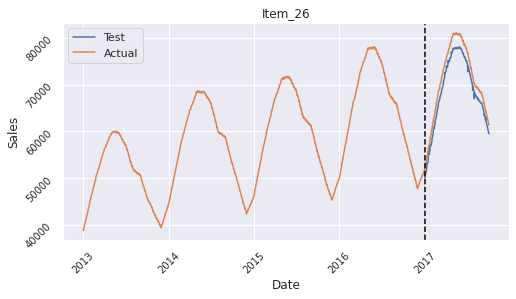

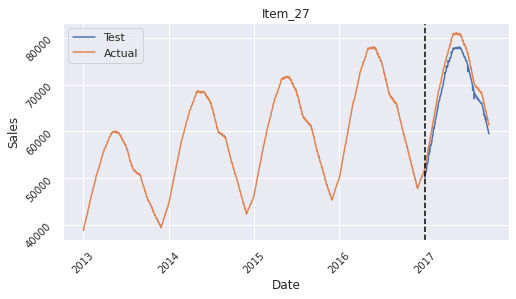

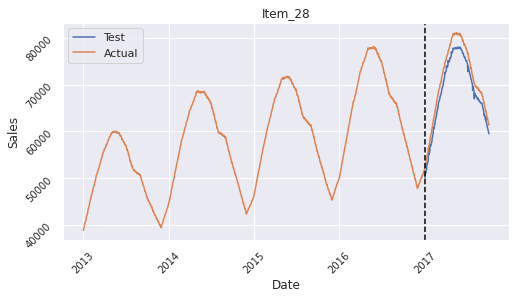

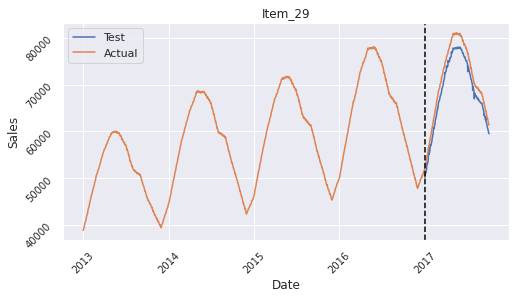

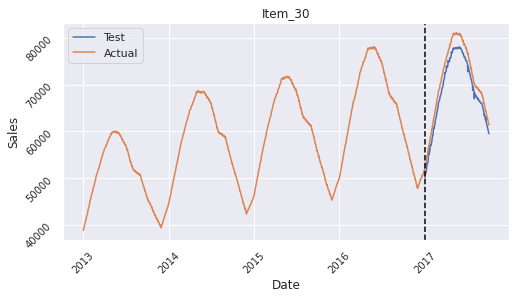

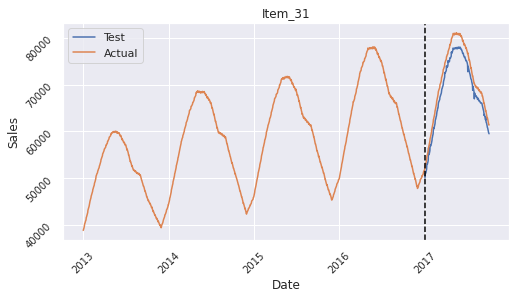

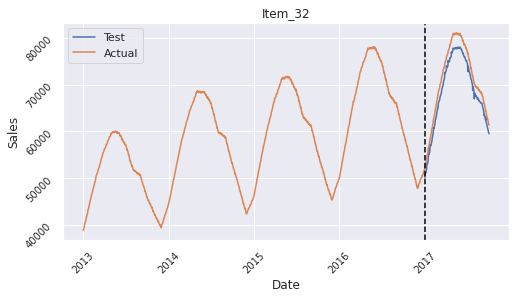

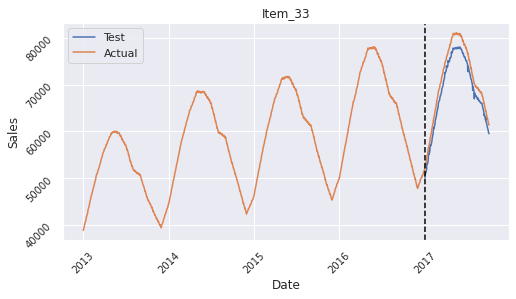

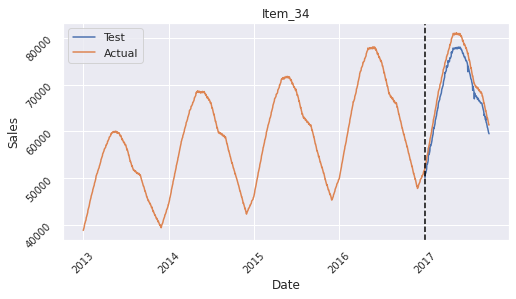

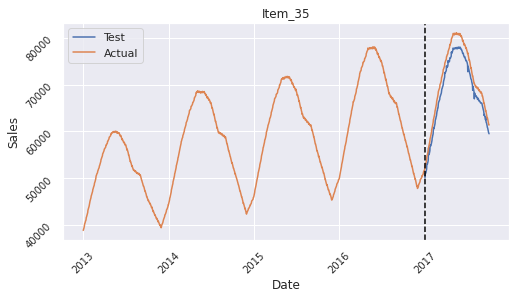

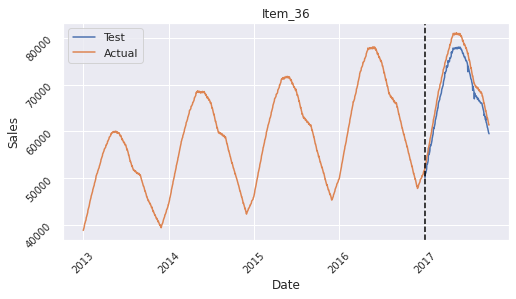

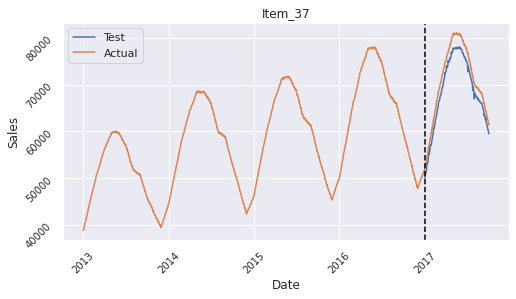

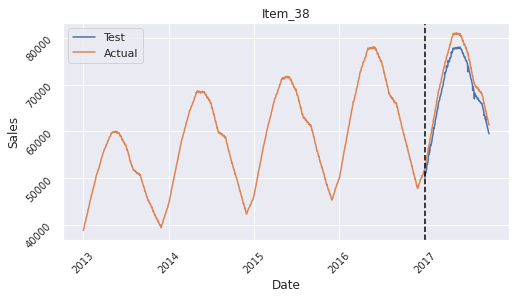

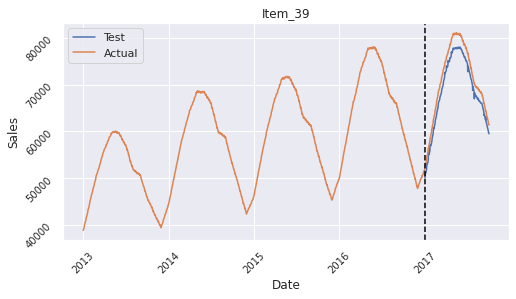

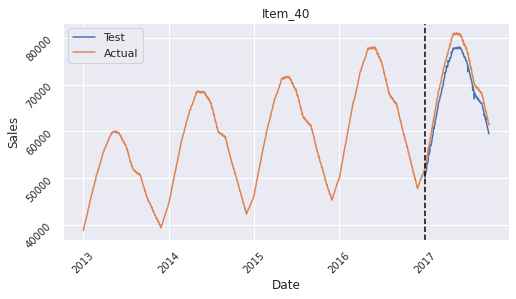

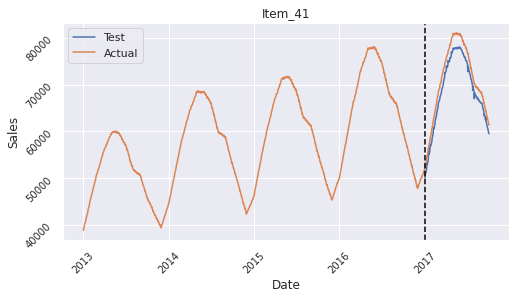

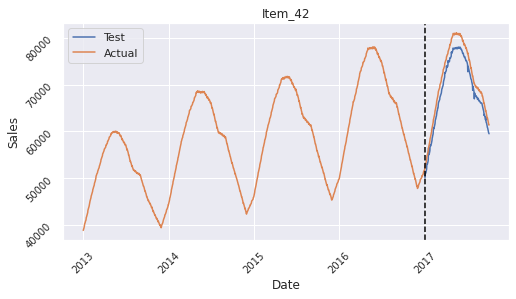

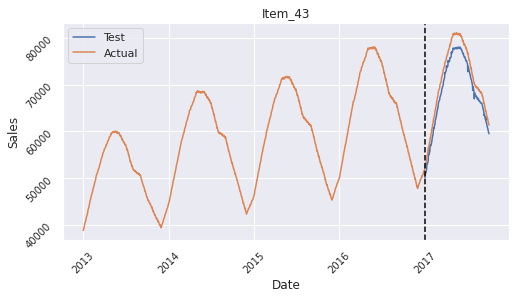

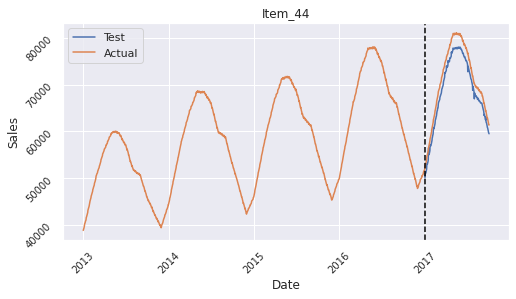

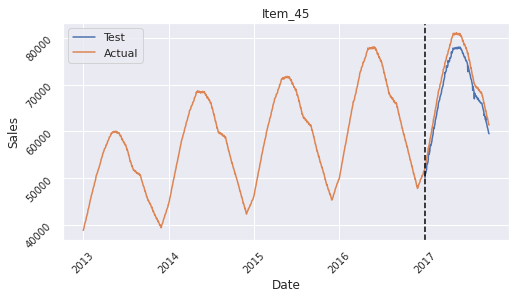

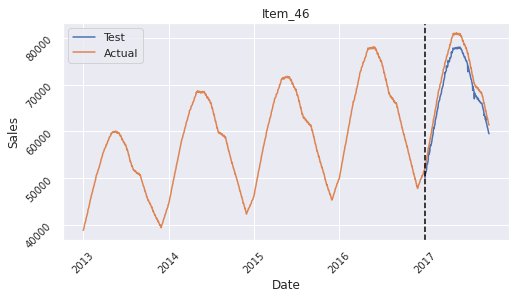

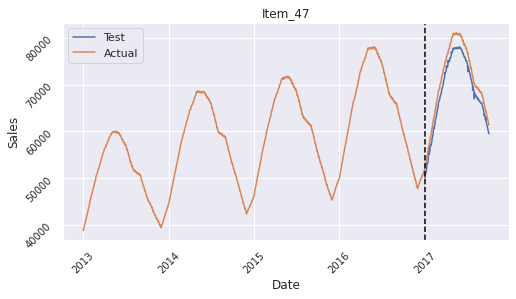

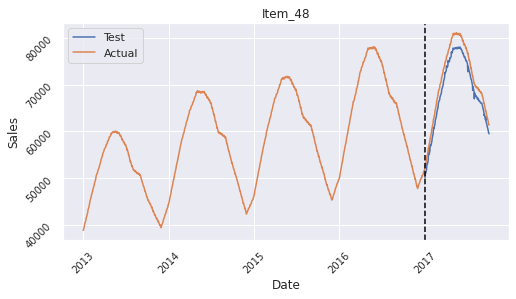

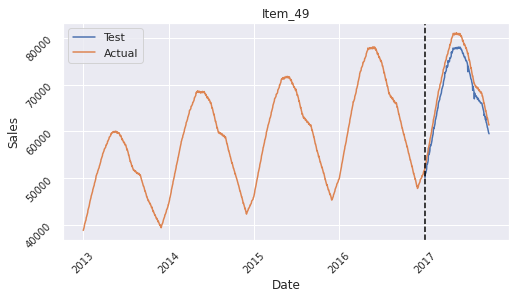

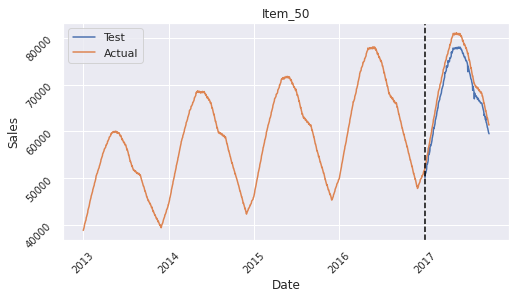

In [ ]:
# plotting forecast and actual sales

for k, v in test_forecast_dict_lr.items():
  forecast = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-02'))
  fig, ax = plt.subplots(figsize=(8,4))
  plt.title(k)
  plt.plot(forecast, label='Test')
  plt.plot(data.sales, label='Actual')
  plt.xlabel('Date', size=12)
  plt.ylabel('Sales', size=12)
  plt.xticks(rotation=45, size=10)
  plt.yticks(rotation=45, size=10)
  ax.axvline(pd.to_datetime('2017-01-01'), color='black', ls='--')  # convert date string to datetime object
  plt.legend(loc='best')
  plt.show()

## **KNN Regresssor**

In [ ]:
df_agg_knn = df_agg.copy()
df_agg_knn

item    sales  day_of_month  month  year  wk_of_year  quarter  \
date                                                                        
2013-01-01     1  12848.0             1      1  2013           1        1   
2013-01-02     1  12936.0             2      1  2013           1        1   
2013-01-03     1  13019.0             3      1  2013           1        1   
2013-01-04     1  13103.0             4      1  2013           1        1   
2013-01-05     1  13153.0             5      1  2013           1        1   
...          ...      ...           ...    ...   ...         ...      ...   
2017-09-28    50  62200.0            28      9  2017          39        3   
2017-09-29    50  61962.0            29      9  2017          39        3   
2017-09-30    50  61687.0            30      9  2017          39        3   
2017-10-01    50  61392.0             1     10  2017          39        4   
2017-10-02    50  61395.0             2     10  2017          40        4   

            is_month_start  is_month_end  is_quarter_start  is_quarter_end  
date                                                                        
2013-01-01               1             0                 1               0  
2013-01-02               0             0                 0               0  
2013-01-03               0             0                 0               0  
2013-01-04               0             0                 0               0  
2013-01-05               0             0                 0               0  
...                    ...           ...               ...             ...  
2017-09-28               0             0                 0               0  
2017-09-29               0             0                 0               0  
2017-09-30               0             1                 0               1  
2017-10-01               1             0                 1               0  
2017-10-02               0             0                 0               0  

[86849 rows x 11 columns]

In [ ]:
# dictionary for collecting the test data predicted results
test_forecast_dict_knn = dict()

# dictionary for collecting the evaluation metrics 
em_dict_knn = dict()

In [ ]:
# running a for loop for all 50 items
for i in list(df_agg_knn['item'].unique()):
 
  # filtering the data item-wise
  split_data_knn = df_agg_knn[df_agg_knn['item']==i].drop(['item'], axis=1)
  
  
  # Splitting the dataset into dependent and independent variable
  x_knn = split_data_knn.drop(['sales'], axis=1)
  y_knn = split_data_knn['sales']
  

  #since it is a time series dataset we should split the train and test data 
  #Taking 2013 to 2016 data as train data
  #Taking 2017 data as test data 
  x_train_knn = x_knn.loc[:'2016-12-31']
  x_test_knn = x_knn.loc['2017-01-01':'2017-10-02'] 
  y_train_knn = y_knn.loc[:'2016-12-31']
  y_test_knn = y_knn.loc['2017-01-01':'2017-10-02']

  # Initializing the model
  knn_model = KNeighborsRegressor(n_neighbors=7)
  
  # Fitting the data to the model
  knn_model.fit(x_train_knn, y_train_knn)

  # predicting the test data
  y_pred_knn = knn_model.predict(x_test_knn)

  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i) #key
  v = y_pred_knn #value
  
  # adding elements to the dictionary
  test_forecast_dict_knn.update({k:v})

  # Performance Evaluation Metrics
  r2_knn = r2_score(y_test_knn, y_pred_knn)
  mse_knn = mean_squared_error(y_test_knn, y_pred_knn)
  rmse_knn = np.sqrt(mse_knn)
  mae_knn = mean_absolute_error(y_test_knn, y_pred_knn)
  mape_knn = mean_absolute_percentage_error(y_test_knn, y_pred_knn)

  # creating a key and value for test_forecast evaluation metrics dictionary
  key_knn = 'Item_'+str(i)
  value_knn = {'r2':r2_knn, 'MSE':mse_knn, 'RMSE':rmse_knn, 'MAE':mae_knn, 'MAPE':mape_knn}
  em_dict_knn.update({key_knn:value_knn})

In [ ]:
test_forecast_dict_knn_df = pd.DataFrame(test_forecast_dict_knn, index=[pd.date_range(start='2017-01-01', end='2017-10-02')])
test_forecast_dict_knn_df = test_forecast_dict_knn_df.reset_index()
test_forecast_dict_knn_df = test_forecast_dict_knn_df.set_index('level_0', drop=True)

In [ ]:
for i in test_forecast_dict_knn_df.columns:
  test_forecast_dict_knn_df[i] = test_forecast_dict_knn_df[i].apply(lambda x:round(x,2))
test_forecast_dict_knn_df

Item_1    Item_2    Item_3    Item_4    Item_5    Item_6  \
level_0                                                                  
2017-01-01  15912.71  42933.86  26730.14  16080.14  13381.29  42542.71   
2017-01-02  15535.86  41851.14  25929.57  15589.71  13051.29  41593.43   
2017-01-03  15914.00  42813.57  26543.43  16008.14  13384.57  42594.00   
2017-01-04  16235.43  43630.86  27070.14  16371.14  13669.86  43462.14   
2017-01-05  16511.71  44417.86  27545.00  16681.71  13918.29  44209.86   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  19381.57  52111.71  32537.43  19418.14  16258.43  51794.86   
2017-09-29  19308.86  51944.29  32415.86  19345.14  16201.14  51617.71   
2017-09-30  18976.86  50906.43  31838.86  19021.29  15877.14  50639.43   
2017-10-01  18849.14  50419.71  31593.86  18831.43  15725.57  50124.43   
2017-10-02  19128.14  51286.00  32077.71  19110.00  16004.14  50935.29   

              Item_7    Item_8    Item_9   Item_10  ...   Item_41   Item_42  \
level_0                                             ...                       
2017-01-01  42550.43  55966.57  37314.57  53571.86  ...  16162.29  26880.71   
2017-01-02  41724.00  54913.29  36436.43  52109.71  ...  15734.57  26107.71   
2017-01-03  42653.00  56190.14  37240.71  53409.00  ...  16130.00  26737.57   
2017-01-04  43428.43  57270.43  37935.00  54513.71  ...  16462.29  27286.86   
2017-01-05  44171.43  58180.00  38586.71  55502.86  ...  16761.57  27776.86   
...              ...       ...       ...       ...  ...       ...       ...   
2017-09-28  51834.29  68269.57  45730.29  64975.43  ...  19502.00  32527.00   
2017-09-29  51659.86  68029.29  45582.86  64741.14  ...  19442.43  32416.71   
2017-09-30  50680.71  66733.43  44757.71  63507.43  ...  19085.14  31804.86   
2017-10-01  50186.57  66106.86  44338.57  62832.71  ...  18906.57  31504.86   
2017-10-02  51002.43  67163.43  45024.86  63861.29  ...  19203.86  32014.71   

             Item_43   Item_44   Item_45   Item_46   Item_47   Item_48  \
level_0                                                                  
2017-01-01  37582.29  21503.14  58709.29  42910.86  16027.29  37211.43   
2017-01-02  36518.86  20947.71  57422.86  41596.57  15674.29  36512.57   
2017-01-03  37407.71  21419.00  58746.86  42642.43  16042.86  37336.57   
2017-01-04  38164.57  21817.57  59871.43  43561.43  16353.29  38034.00   
2017-01-05  38832.14  22201.14  60847.29  44356.57  16621.00  38632.29   
...              ...       ...       ...       ...       ...       ...   
2017-09-28  45587.43  25987.86  71344.29  52041.14  19583.86  45537.29   
2017-09-29  45425.29  25878.14  71088.86  51876.14  19516.43  45362.29   
2017-09-30  44553.86  25404.71  69768.86  50895.43  19146.29  44539.00   
2017-10-01  44149.71  25158.71  69139.14  50418.00  18964.00  44117.57   
2017-10-02  44870.71  25539.29  70258.57  51243.14  19268.14  44814.57   

             Item_49   Item_50  
level_0                         
2017-01-01  21200.14  47953.29  
2017-01-02  20763.57  46754.71  
2017-01-03  21238.71  47853.29  
2017-01-04  21650.71  48788.14  
2017-01-05  21994.14  49660.14  
...              ...       ...  
2017-09-28  25905.86  58426.57  
2017-09-29  25825.00  58243.57  
2017-09-30  25416.00  57191.14  
2017-10-01  25201.86  56705.00  
2017-10-02  25545.86  57584.71  

[275 rows x 50 columns]

In [ ]:
# Dataframe for Evaluation metrics
em_dict_knn_df = pd.DataFrame(em_dict_knn)

for i in em_dict_xgb_df.columns:
  em_dict_knn_df[i] = em_dict_knn_df[i].apply(lambda x:round(x,2))

em_dict_knn_df.T

r2          MSE     RMSE      MAE  MAPE
Item_1   0.69   2123909.70  1457.36  1435.18  0.06
Item_2   0.62  17926765.35  4234.00  4153.47  0.07
Item_3   0.60   7285894.26  2699.24  2667.28  0.07
Item_4   0.71   1995534.47  1412.63  1381.95  0.06
Item_5   0.63   1659789.67  1288.33  1270.61  0.06
Item_6   0.66  15651865.81  3956.24  3890.42  0.06
Item_7   0.67  15663642.37  3957.73  3895.67  0.06
Item_8   0.59  33209326.55  5762.75  5685.36  0.07
Item_9   0.65  11615517.06  3408.15  3355.27  0.06
Item_10  0.57  30160043.11  5491.82  5435.01  0.07
Item_11  0.63  25030089.11  5003.01  4926.86  0.07
Item_12  0.63  24429876.86  4942.66  4880.25  0.07
Item_13  0.61  37402921.38  6115.79  6035.26  0.07
Item_14  0.63  16981042.33  4120.81  4064.30  0.06
Item_15  0.64  38059011.31  6169.20  6074.17  0.06
Item_16  0.61   3297539.22  1815.91  1793.29  0.07
Item_17  0.68   4596714.67  2144.00  2103.73  0.06
Item_18  0.62  38478077.49  6203.07  6095.63  0.07
Item_19  0.58   9257009.34  3042.53  3000.45  0.07
Item_20  0.64  10400874.29  3225.04  3193.60  0.06
Item_21  0.62   8292924.78  2879.74  2836.21  0.07
Item_22  0.64  29990297.26  5476.34  5411.13  0.06
Item_23  0.62   4374029.32  2091.42  2060.28  0.07
Item_24  0.64  20692192.79  4548.87  4497.24  0.06
Item_25  0.66  30828421.64  5552.33  5463.46  0.06
Item_26  0.60  11826107.55  3438.91  3398.01  0.07
Item_27  0.67   2436268.86  1560.86  1507.83  0.06
Item_28  0.61  39271771.19  6266.72  6192.56  0.07
Item_29  0.60  25447185.10  5044.52  4996.92  0.07
Item_30  0.62   8502905.19  2915.97  2867.05  0.07
Item_31  0.63  16610478.91  4075.60  4020.74  0.06
Item_32  0.56  12007653.39  3465.21  3411.45  0.07
Item_33  0.60  26734925.27  5170.58  5093.39  0.07
Item_34  0.62   3236548.13  1799.04  1770.77  0.06
Item_35  0.61  22099866.78  4701.05  4657.48  0.07
Item_36  0.64  28152542.49  5305.90  5238.20  0.06
Item_37  0.60   4533594.31  2129.22  2105.61  0.07
Item_38  0.62  32787212.99  5726.01  5658.82  0.07
Item_39  0.62   9619476.72  3101.53  3060.38  0.06
Item_40  0.60   4761414.82  2182.07  2153.90  0.07
Item_41  0.64   2617950.70  1618.01  1567.71  0.07
Item_42  0.67   5725910.37  2392.89  2363.72  0.06
Item_43  0.57  15081267.11  3883.46  3826.98  0.07
Item_44  0.64   4301053.11  2073.90  2041.46  0.06
Item_45  0.60  35489963.41  5957.35  5888.25  0.07
Item_46  0.66  16346503.87  4043.08  3984.37  0.06
Item_47  0.59   2857788.76  1690.50  1653.28  0.07
Item_48  0.58  13942729.34  3734.00  3700.63  0.07
Item_49  0.60   4684049.60  2164.27  2143.57  0.07
Item_50  0.66  20587982.63  4537.40  4456.98  0.06

# **Average of Evaluation Metrics**

### XG Boost 

In [ ]:
avg_r2_xgb = em_dict_xgb_df.loc['r2',:].mean()
avg_rmse_xgb = em_dict_xgb_df.loc['RMSE',:].mean()
print("The average r2 score all items",avg_r2_xgb)
print("The average RMSE score all items",avg_rmse_xgb)

The average r2 score all items 0.8802
The average RMSE score all items 2096.54


### Decision Tree

In [ ]:
avg_r2_dt = em_dict_dt_df.loc['r2',:].mean()
avg_rmse_dt = em_dict_dt_df.loc['RMSE',:].mean()
print("The average r2 score all items",round((avg_r2_dt),2))
print("The average RMSE score all items",round((avg_rmse_dt),2))

The average r2 score all items 0.88
The average RMSE score all items 2125.8


### KNN Regressor

In [ ]:
avg_r2_knn = em_dict_knn_df.loc['r2',:].mean()
avg_rmse_knn = em_dict_knn_df.loc['RMSE',:].mean()
print("The average r2 score all items",round((avg_r2_knn),2))
print("The average RMSE score all items",round((avg_rmse_knn),2))

The average r2 score all items 0.63
The average RMSE score all items 3719.54


### Random Forest Model

In [ ]:
avg_r2_rf = em_dict_rf_df.loc['r2',:].mean()
avg_rmse_rf = em_dict_rf_df.loc['RMSE',:].mean()
print("The average r2 score all items",round((avg_r2_rf),2))
print("The average RMSE score all items",round((avg_rmse_rf),2))

The average r2 score all items 0.86
The average RMSE score all items 2292.53


XG Boost Model perfomed well compared to all other models